Jeszcze inne podejście. Wracam do koncepcji, że "churn" w datasecie oznacza rezygnacje, które już nastąpiły, a chcemy przewidzieć przyszłe. Będę bazować na podziale datasetu na 3 części:
rc = 0, ta część tylko do analizy, żeby wykminić, jakimi innymi cechami się wyróżniają, a nie tylko rc;
rc = NaN, na tych będę trenować i testować model, w oparciu o założenie, że jeżeli ktoś ma umowę na czas nieokreślony, to mógłby już zrezygnować, gdyby chciał;
rc > 0 tylko do testów, tam jeżeli churn=1, to model powinien dać wynik churn=1, jeżeli churn =0, to model może dać wynik churn =0 i przez to rozumiemy, że on raczej przedłuży umowę, albo churn =1, i to znaczy, że raczej nie przedłuży;
Testy na rc = NaN powinny dawać najwyższe wyniki;
Trenowanie na rc > 0 może być niemiarodajne, bo delikwent może i chciałby zreygnować ale trzyma go umowa i nie chce płacić "kary"

Istotne obserwacje dla tego podejścia:
Model ma przewidywać, kto zrezygnuje, gdy skończy mu się umowa, więc nie ma sensu trenować go na próbkach, dla których "remaining_contract" = 0. Zresztą w tej grupie prawie 100% ma wartość churn = 1.  
Usuwam je i wtedy NaN zastąpię 0



Czy mam wczytać podział do podejścia drugiego? (wyodrębnienie z rc=NaN i ch=1 części w celu wyrównania ch1 i ch0)

In [ ]:
load_data = 0

Czy mam zapisać dokonany podział z podejścia drugiego?

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functions as fns
import joblib

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from scipy.stats import mstats


from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from xgboost.sklearn import XGBClassifier


scaler = StandardScaler()

In [ ]:
df = pd.read_csv("new_isc_04.csv" )
print(df.shape, "\n", df.head())

(62274, 11) 
    id  is_tv_subscriber  is_movie_package_subscriber  subscription_age  \
0  15                 1                            0             11.95   
1  18                 0                            0              8.22   
2  23                 1                            0              8.91   
3  27                 0                            0              6.87   
4  34                 0                            0              6.39   

   bill_avg  remaining_contract  service_failure_count  download_avg  \
0        25                0.14                      0           8.4   
1         0                 NaN                      0           0.0   
2        16                0.00                      0          13.7   
3        21                 NaN                      1           0.0   
4         0                 NaN                      0           0.0   

   upload_avg  download_over_limit  churn  
0         2.3                    0      0  
1         0.0       

In [ ]:
cols = df.columns
print(cols)

Index(['id', 'is_tv_subscriber', 'is_movie_package_subscriber',
       'subscription_age', 'bill_avg', 'remaining_contract',
       'service_failure_count', 'download_avg', 'upload_avg',
       'download_over_limit', 'churn'],
      dtype='object')


In [ ]:
id = cols[0]
its = cols[1]
imps = cols[2]
sa = cols[3]
ba = cols[4]
rc = cols[5]
sfc = cols[6]
da = cols[7]
ua = cols[8]
dol = cols[9]
ch = cols[10]

shorts = [id, its, imps, sa, ba, rc, sfc, da, ua, dol, ch]

In [ ]:
for i in range(11):
  print(cols[i], shorts[i] == cols[i])

id True
is_tv_subscriber True
is_movie_package_subscriber True
subscription_age True
bill_avg True
remaining_contract True
service_failure_count True
download_avg True
upload_avg True
download_over_limit True
churn True


In [ ]:
def Xy_split(df: pd.DataFrame):

  cols = df.columns
  X = df[cols[0:-1]]
  y = df[cols[-1]]


  return X, y

In [ ]:
def std_machine(df: pd.DataFrame):

  last_col = df.columns[-1]
  X, y = Xy_split(df)
  cols = X.columns
  X = scaler.fit_transform(X)
  X = pd.DataFrame(X, columns=cols)
  y = y.to_numpy()
  y = pd.Series(y, name=last_col)

  new_df = pd.concat([X, y], axis=1)


  return new_df


In [ ]:
def std_machine_only_trans(df: pd.DataFrame):

  last_col = df.columns[-1]
  X, y = Xy_split(df)
  cols = X.columns
  X = scaler.transform(X)
  X = pd.DataFrame(X, columns=cols)
  y = y.to_numpy()
  y = pd.Series(y, name=last_col)

  new_df = pd.concat([X, y], axis=1)


  return new_df

In [ ]:
def winsorize_data(df, columns, limits=[0.00, 0.001]):
    for column in columns:
        df[column] = mstats.winsorize(df[column], limits=limits)
    return df


array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'is_tv_subscriber'}>,
        <Axes: title={'center': 'is_movie_package_subscriber'}>],
       [<Axes: title={'center': 'subscription_age'}>,
        <Axes: title={'center': 'bill_avg'}>,
        <Axes: title={'center': 'remaining_contract'}>],
       [<Axes: title={'center': 'service_failure_count'}>,
        <Axes: title={'center': 'download_avg'}>,
        <Axes: title={'center': 'upload_avg'}>],
       [<Axes: title={'center': 'download_over_limit'}>,
        <Axes: title={'center': 'churn'}>, <Axes: >]], dtype=object)

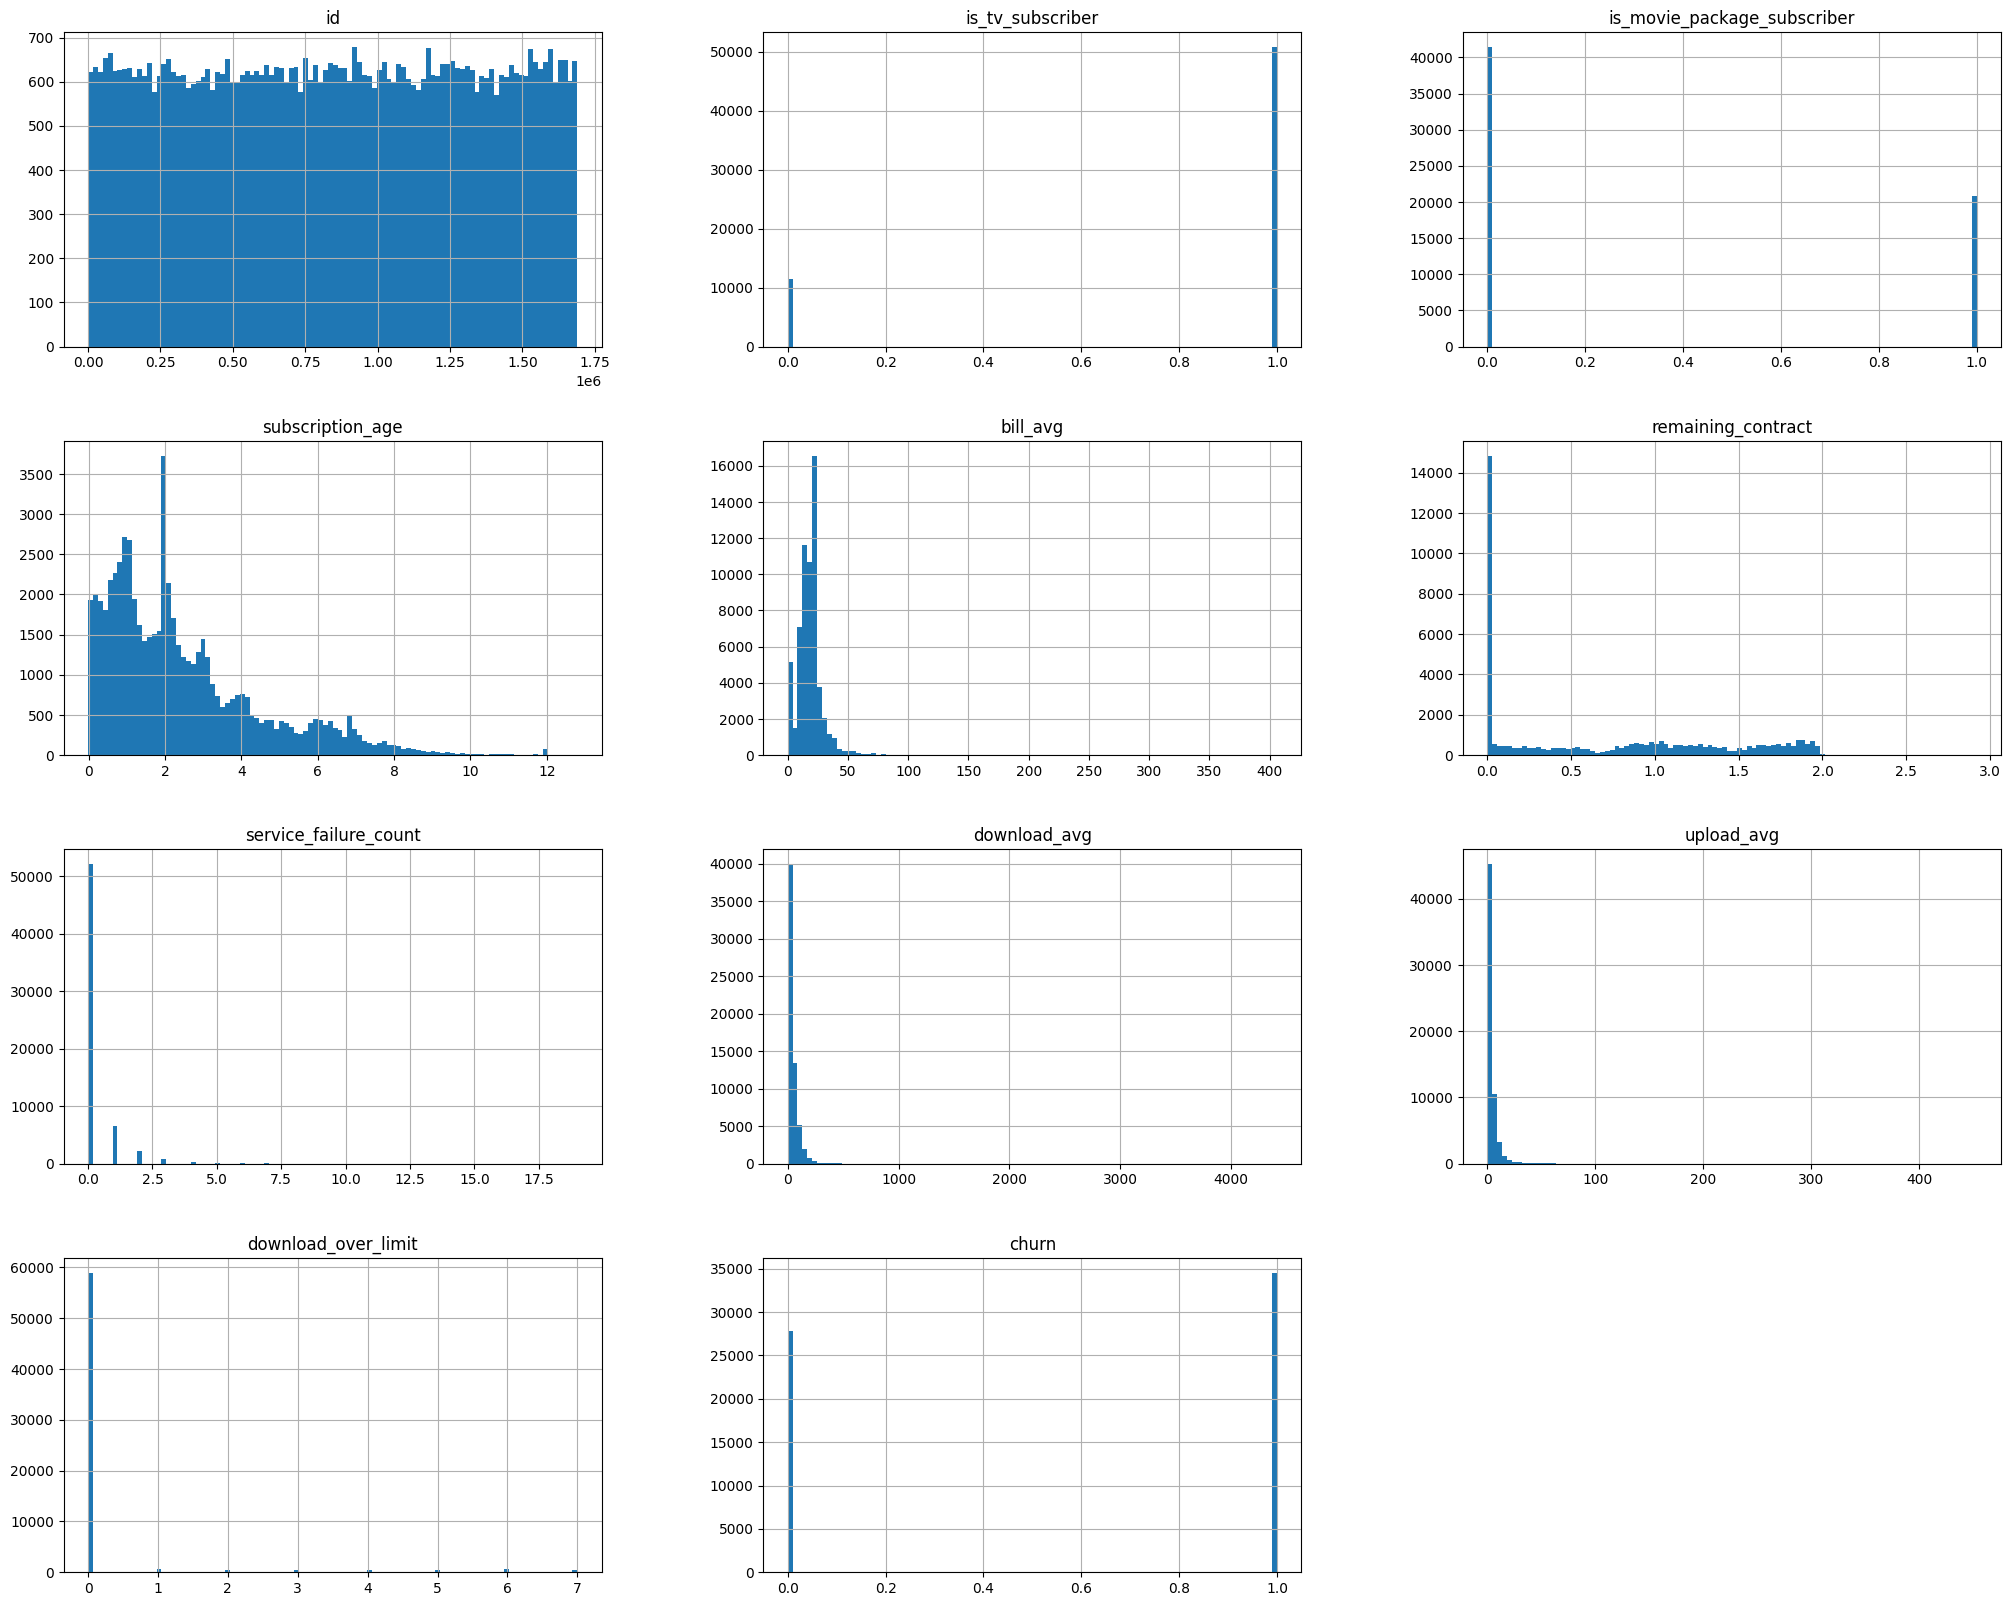

In [ ]:
df.hist(bins=100, figsize=(25, 20))

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'is_tv_subscriber'}>,
        <Axes: title={'center': 'is_movie_package_subscriber'}>],
       [<Axes: title={'center': 'subscription_age'}>,
        <Axes: title={'center': 'bill_avg'}>,
        <Axes: title={'center': 'remaining_contract'}>],
       [<Axes: title={'center': 'service_failure_count'}>,
        <Axes: title={'center': 'download_avg'}>,
        <Axes: title={'center': 'upload_avg'}>],
       [<Axes: title={'center': 'download_over_limit'}>,
        <Axes: title={'center': 'churn'}>, <Axes: >]], dtype=object)

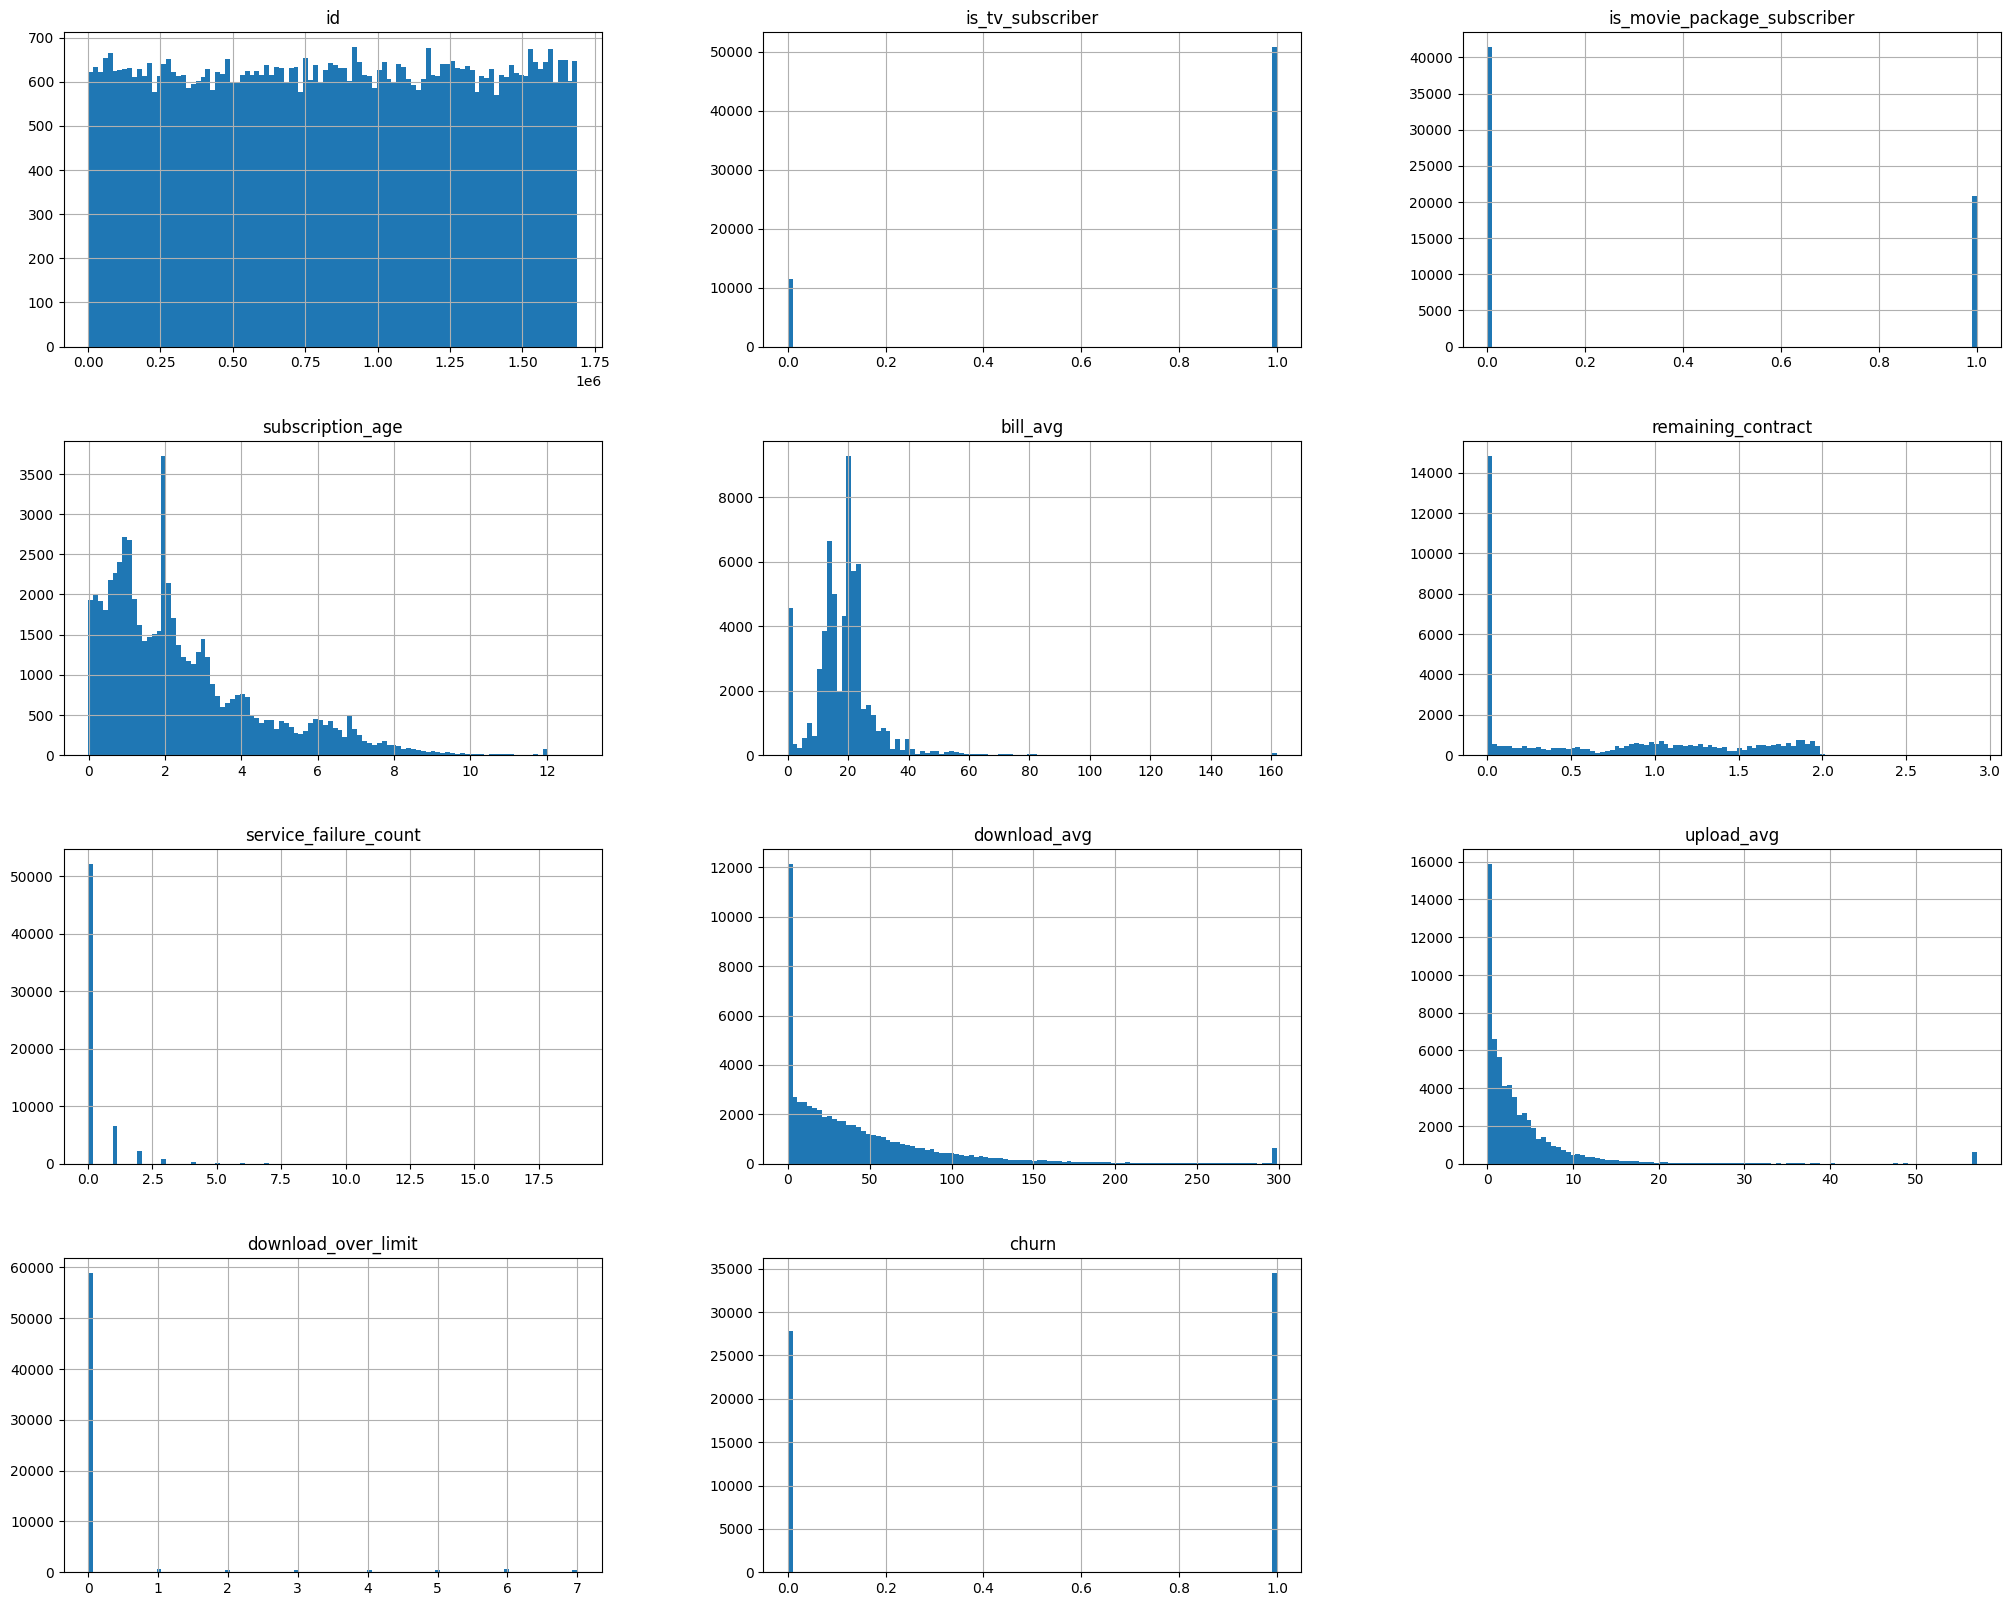

In [ ]:
winsorize_data(df, [ba], limits=[0.00, 0.001])
winsorize_data(df, [da, ua], limits=[0.00, 0.01])
df.hist(bins=100, figsize=(25, 20))

Podział datasetu ze względu na rc

In [ ]:

bool_vecs_rc = {
              "rc = 0": df[rc] == 0,
              "rc > 0": df[rc] > 0,
              "rc = NaN": df[rc].isna(),
            }

df_subs_rc = fns.create_subdfs_list(df, bool_vecs_rc)

(14141, 11)
(29609, 11)
(18524, 11)


In [ ]:
df_subs_rc[0].describe()

id  is_tv_subscriber  is_movie_package_subscriber  \
count  1.414100e+04      14141.000000                 14141.000000   
mean   7.621214e+05          0.776748                     0.183650   
std    3.780414e+05          0.416440                     0.387212   
min    2.300000e+01          0.000000                     0.000000   
25%    4.701630e+05          1.000000                     0.000000   
50%    7.506320e+05          1.000000                     0.000000   
75%    1.050850e+06          1.000000                     0.000000   
max    1.687454e+06          1.000000                     1.000000   

       subscription_age      bill_avg  remaining_contract  \
count      14141.000000  14141.000000             14141.0   
mean           1.773168     18.374019                 0.0   
std            1.579769     10.639139                 0.0   
min            0.000000      0.000000                 0.0   
25%            0.710000     13.000000                 0.0   
50%            1.300000     19.000000                 0.0   
75%            2.100000     22.000000                 0.0   
max           11.420000    162.000000                 0.0   

       service_failure_count  download_avg    upload_avg  download_over_limit  \
count            14141.00000  14141.000000  14141.000000         14141.000000   
mean                 0.29913     29.887830      3.000983             0.126017   
std                  0.86544     38.140863      5.867966             0.745256   
min                  0.00000      0.000000      0.000000             0.000000   
25%                  0.00000      1.300000      0.100000             0.000000   
50%                  0.00000     17.600000      1.200000             0.000000   
75%                  0.00000     43.300000      3.400000             0.000000   
max                 18.00000    298.700000     57.100000             7.000000   

              churn  
count  14141.000000  
mean       0.995545  
std        0.066600  
min        0.000000  
25%        1.000000  
50%        1.000000  
75%        1.000000  
max        1.000000

In [ ]:
df_subs_rc[1].describe()

id  is_tv_subscriber  is_movie_package_subscriber  \
count  2.960900e+04      29609.000000                 29609.000000   
mean   1.092628e+06          0.948732                     0.501199   
std    4.565304e+05          0.220548                     0.500007   
min    1.500000e+01          0.000000                     0.000000   
25%    8.042970e+05          1.000000                     0.000000   
50%    1.208777e+06          1.000000                     1.000000   
75%    1.473959e+06          1.000000                     1.000000   
max    1.689733e+06          1.000000                     1.000000   

       subscription_age      bill_avg  remaining_contract  \
count      29609.000000  29609.000000        29609.000000   
mean           2.552552     18.233983            1.056635   
std            2.274000      9.291842            0.597565   
min           -0.020000      0.000000            0.010000   
25%            0.800000     13.000000            0.540000   
50%            1.830000     17.000000            1.070000   
75%            3.710000     22.000000            1.600000   
max           12.760000    162.000000            2.920000   

       service_failure_count  download_avg    upload_avg  download_over_limit  \
count           29609.000000  29609.000000  29609.000000         29609.000000   
mean                0.259313     62.713047      5.812625             0.050255   
std                 0.777300     57.219506      8.399832             0.448858   
min                 0.000000      0.000000      0.000000             0.000000   
25%                 0.000000     24.000000      1.700000             0.000000   
50%                 0.000000     47.100000      3.600000             0.000000   
75%                 0.000000     83.200000      6.600000             0.000000   
max                16.000000    298.700000     57.100000             7.000000   

              churn  
count  29609.000000  
mean       0.118241  
std        0.322899  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

In [ ]:
df_subs_rc[2].describe()

id  is_tv_subscriber  is_movie_package_subscriber  \
count  1.852400e+04      18524.000000                 18524.000000   
mean   5.166042e+05          0.629562                     0.184679   
std    3.885046e+05          0.482935                     0.388048   
min    1.800000e+01          0.000000                     0.000000   
25%    1.830992e+05          0.000000                     0.000000   
50%    4.488405e+05          1.000000                     0.000000   
75%    7.611372e+05          1.000000                     0.000000   
max    1.689600e+06          1.000000                     1.000000   

       subscription_age      bill_avg  remaining_contract  \
count      18524.000000  18524.000000                 0.0   
mean           2.808802     20.383071                 NaN   
std            1.807481     16.582718                 NaN   
min            0.000000      0.000000                 NaN   
25%            1.900000     13.000000                 NaN   
50%            2.320000     21.000000                 NaN   
75%            3.550000     24.000000                 NaN   
max           12.800000    162.000000                 NaN   

       service_failure_count  download_avg    upload_avg  download_over_limit  \
count            18524.00000  18524.000000  18524.000000         18524.000000   
mean                 0.27548     25.156921      2.656219             0.518948   
std                  0.84165     43.295572      6.509631             1.562710   
min                  0.00000      0.000000      0.000000             0.000000   
25%                  0.00000      0.000000      0.000000             0.000000   
50%                  0.00000      9.100000      0.700000             0.000000   
75%                  0.00000     30.525000      2.500000             0.000000   
max                 19.00000    298.700000     57.100000             7.000000   

              churn  
count  18524.000000  
mean       0.913518  
std        0.281083  
min        0.000000  
25%        1.000000  
50%        1.000000  
75%        1.000000  
max        1.000000

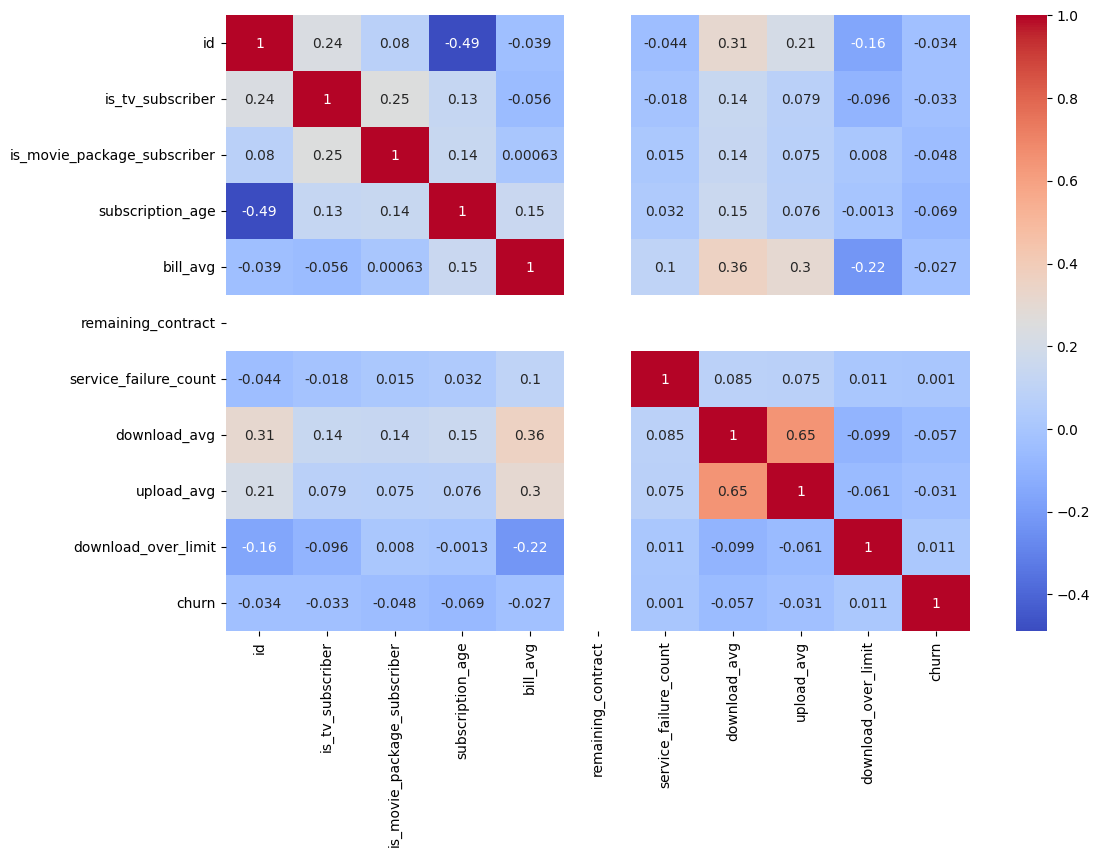

In [ ]:
fns.plot_corelations(df_subs_rc[0])

[rys. 1. Macierz korelacji dla podzbioru próbek z wartością rc = 0]

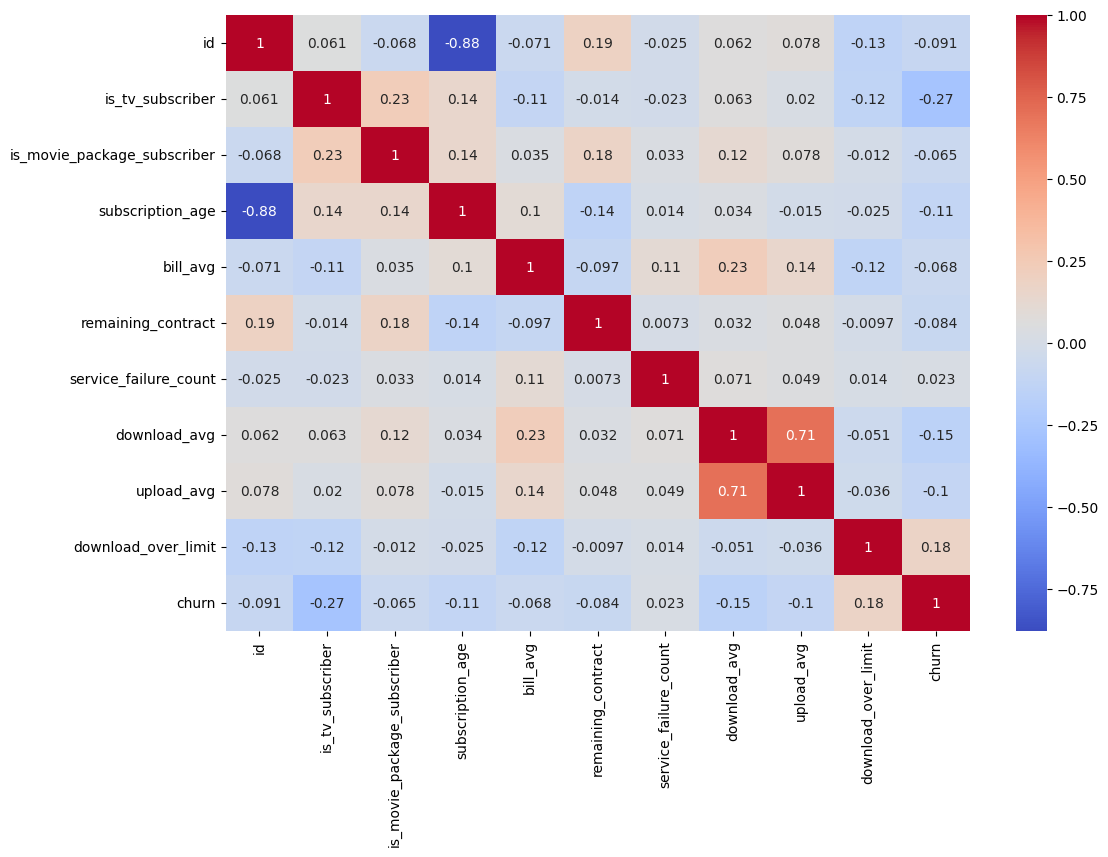

In [ ]:
fns.plot_corelations(df_subs_rc[1])

[rys. 2. Macierz korelacji dla podzbioru próbek z wartością rc > 0]

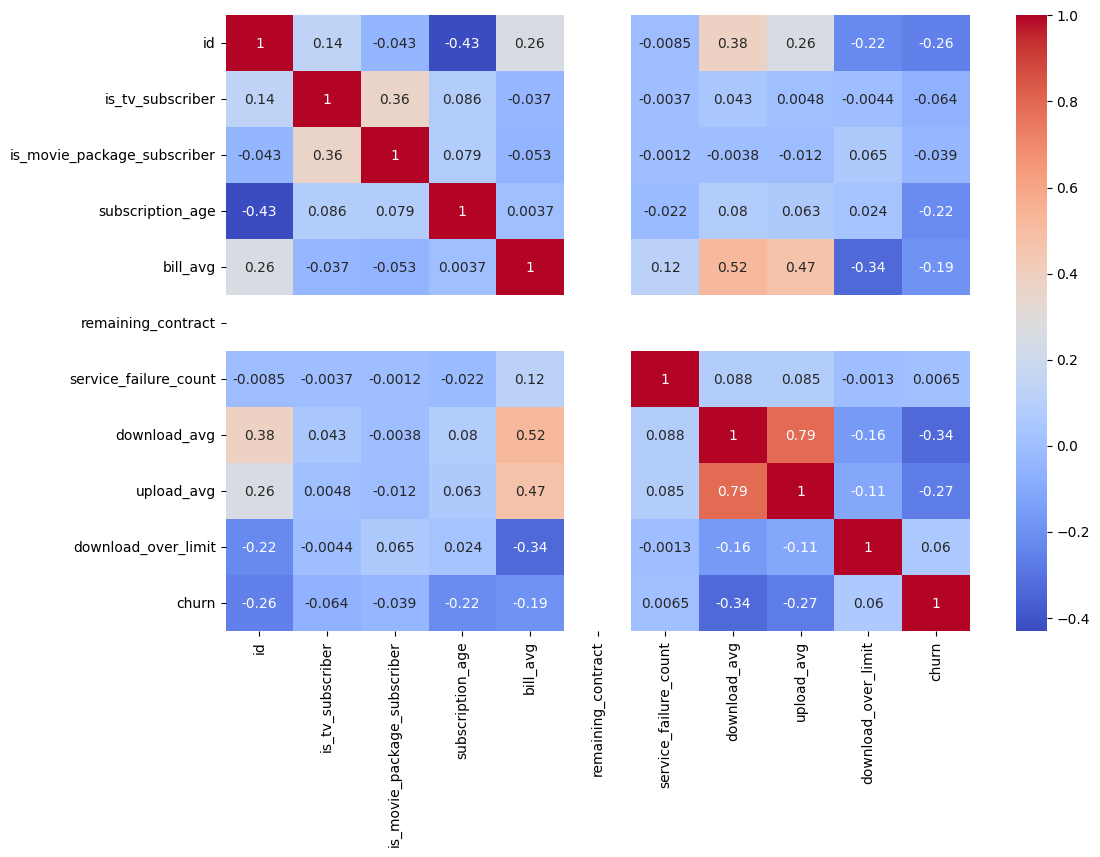

In [ ]:
fns.plot_corelations(df_subs_rc[2])

[rys. 3. Macierz korelacji dla podzbioru próbek z wartością rc = NaN]

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'is_tv_subscriber'}>,
        <Axes: title={'center': 'is_movie_package_subscriber'}>],
       [<Axes: title={'center': 'subscription_age'}>,
        <Axes: title={'center': 'bill_avg'}>,
        <Axes: title={'center': 'remaining_contract'}>],
       [<Axes: title={'center': 'service_failure_count'}>,
        <Axes: title={'center': 'download_avg'}>,
        <Axes: title={'center': 'upload_avg'}>],
       [<Axes: title={'center': 'download_over_limit'}>,
        <Axes: title={'center': 'churn'}>, <Axes: >]], dtype=object)

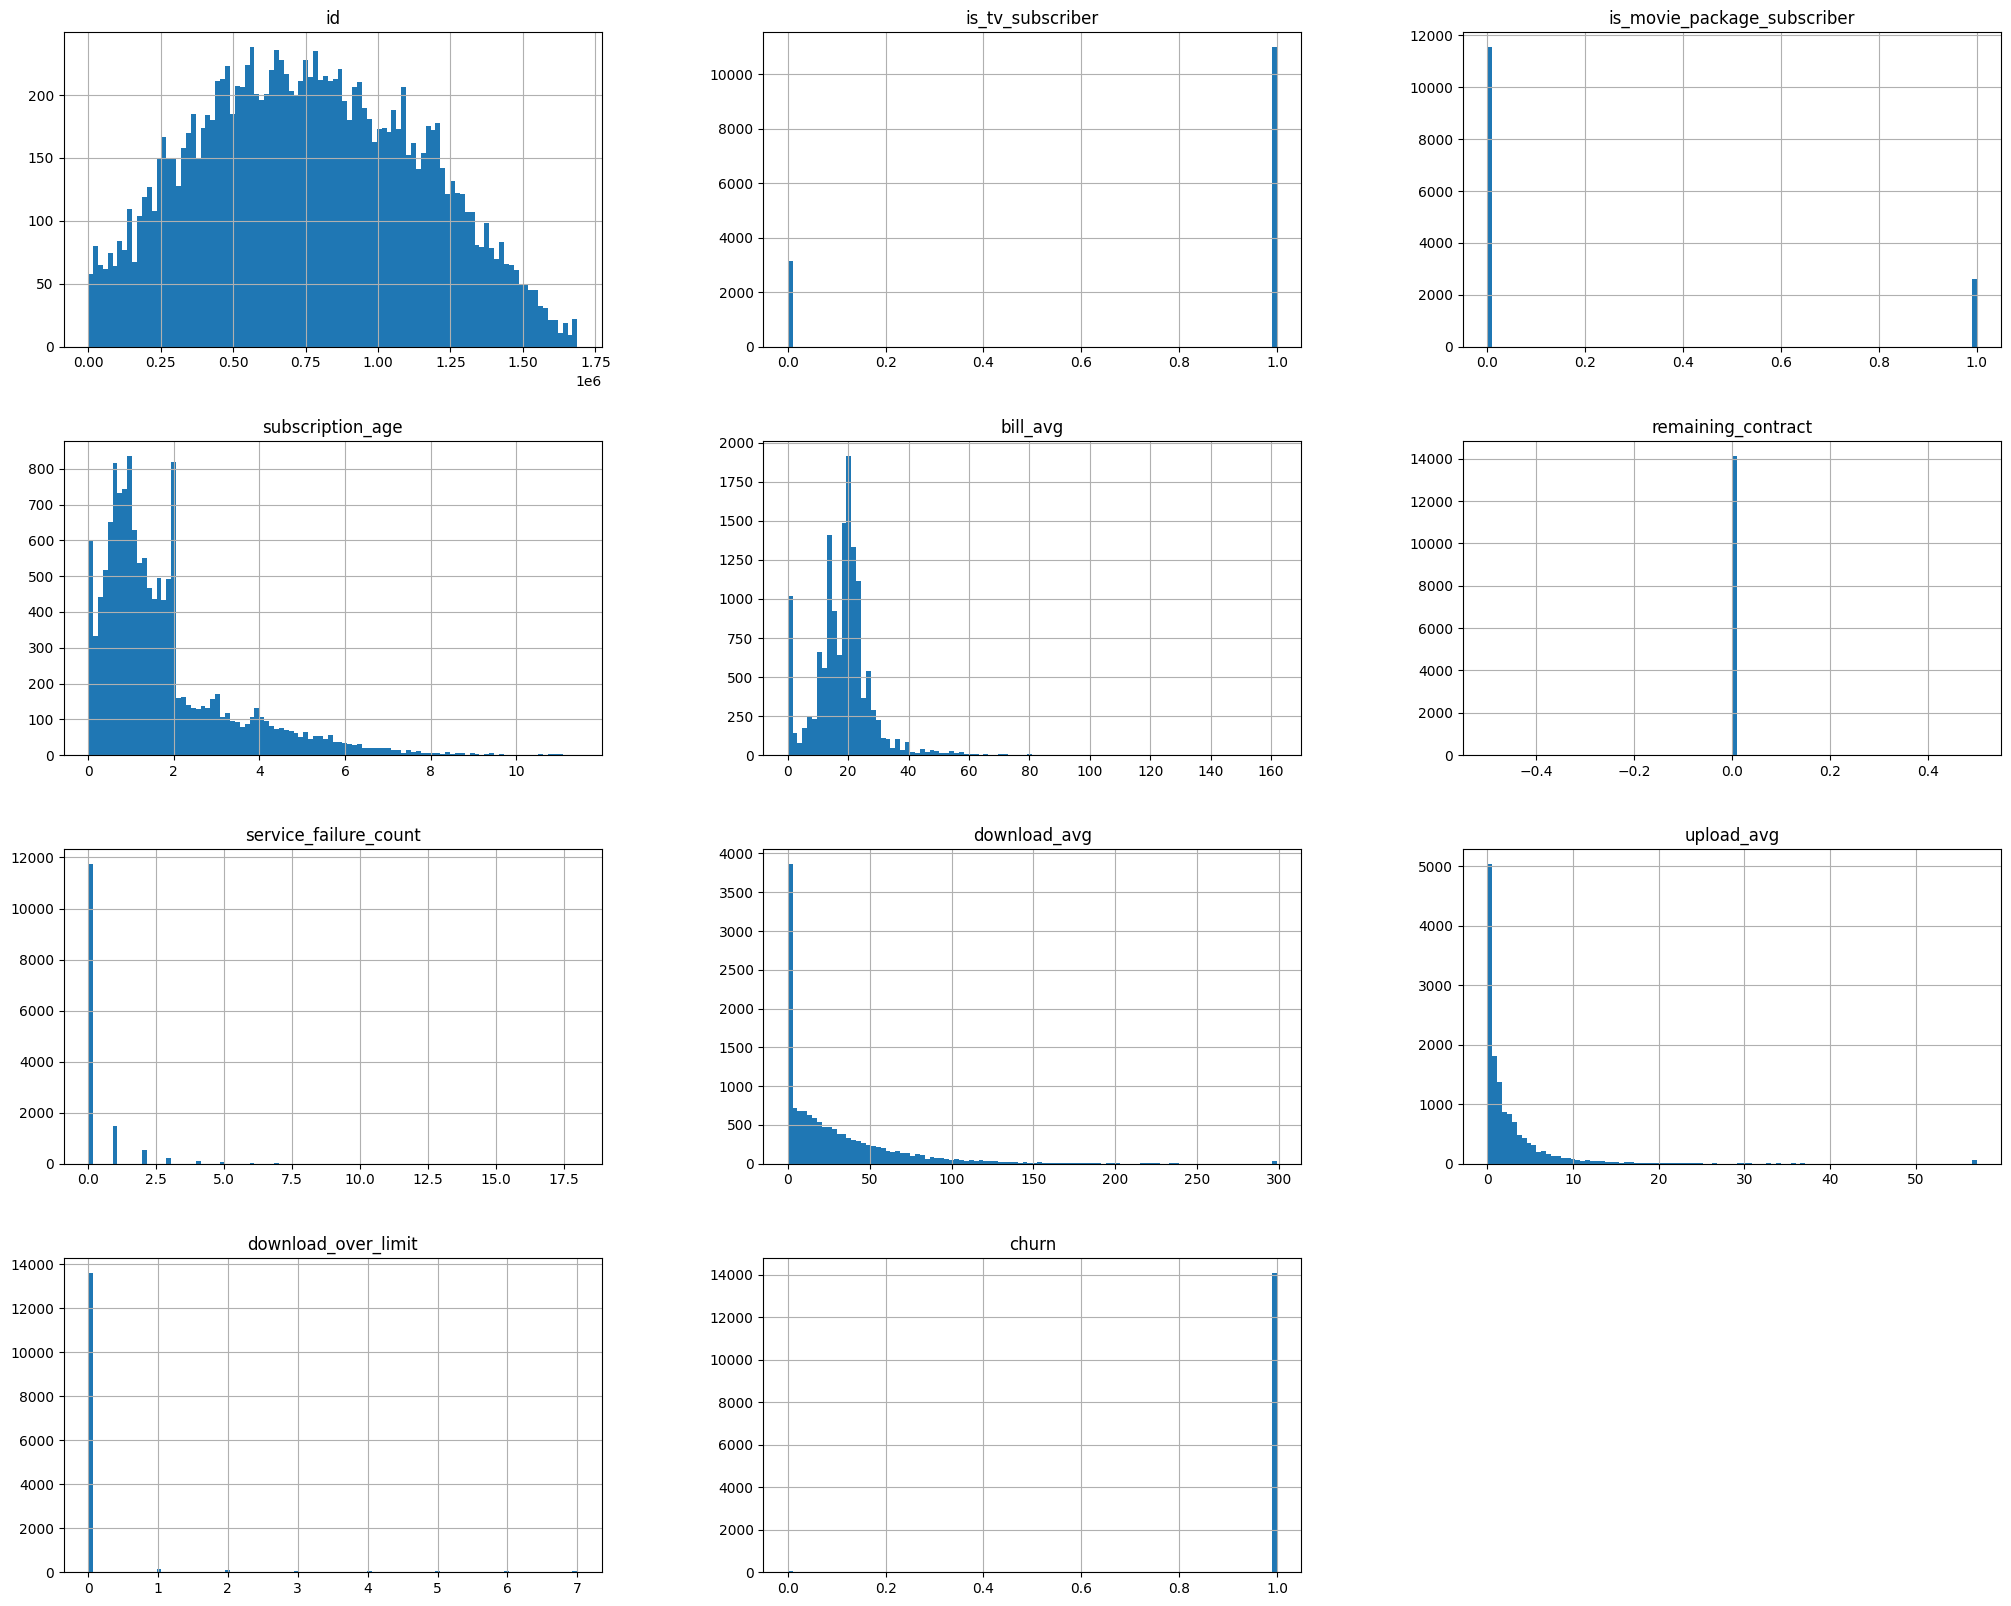

In [ ]:
df_subs_rc[0].hist(bins=100, figsize=(25, 20))

[rys. 4. Histogramy dla podzbioru próbek z wartością rc = 0]

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'is_tv_subscriber'}>,
        <Axes: title={'center': 'is_movie_package_subscriber'}>],
       [<Axes: title={'center': 'subscription_age'}>,
        <Axes: title={'center': 'bill_avg'}>,
        <Axes: title={'center': 'remaining_contract'}>],
       [<Axes: title={'center': 'service_failure_count'}>,
        <Axes: title={'center': 'download_avg'}>,
        <Axes: title={'center': 'upload_avg'}>],
       [<Axes: title={'center': 'download_over_limit'}>,
        <Axes: title={'center': 'churn'}>, <Axes: >]], dtype=object)

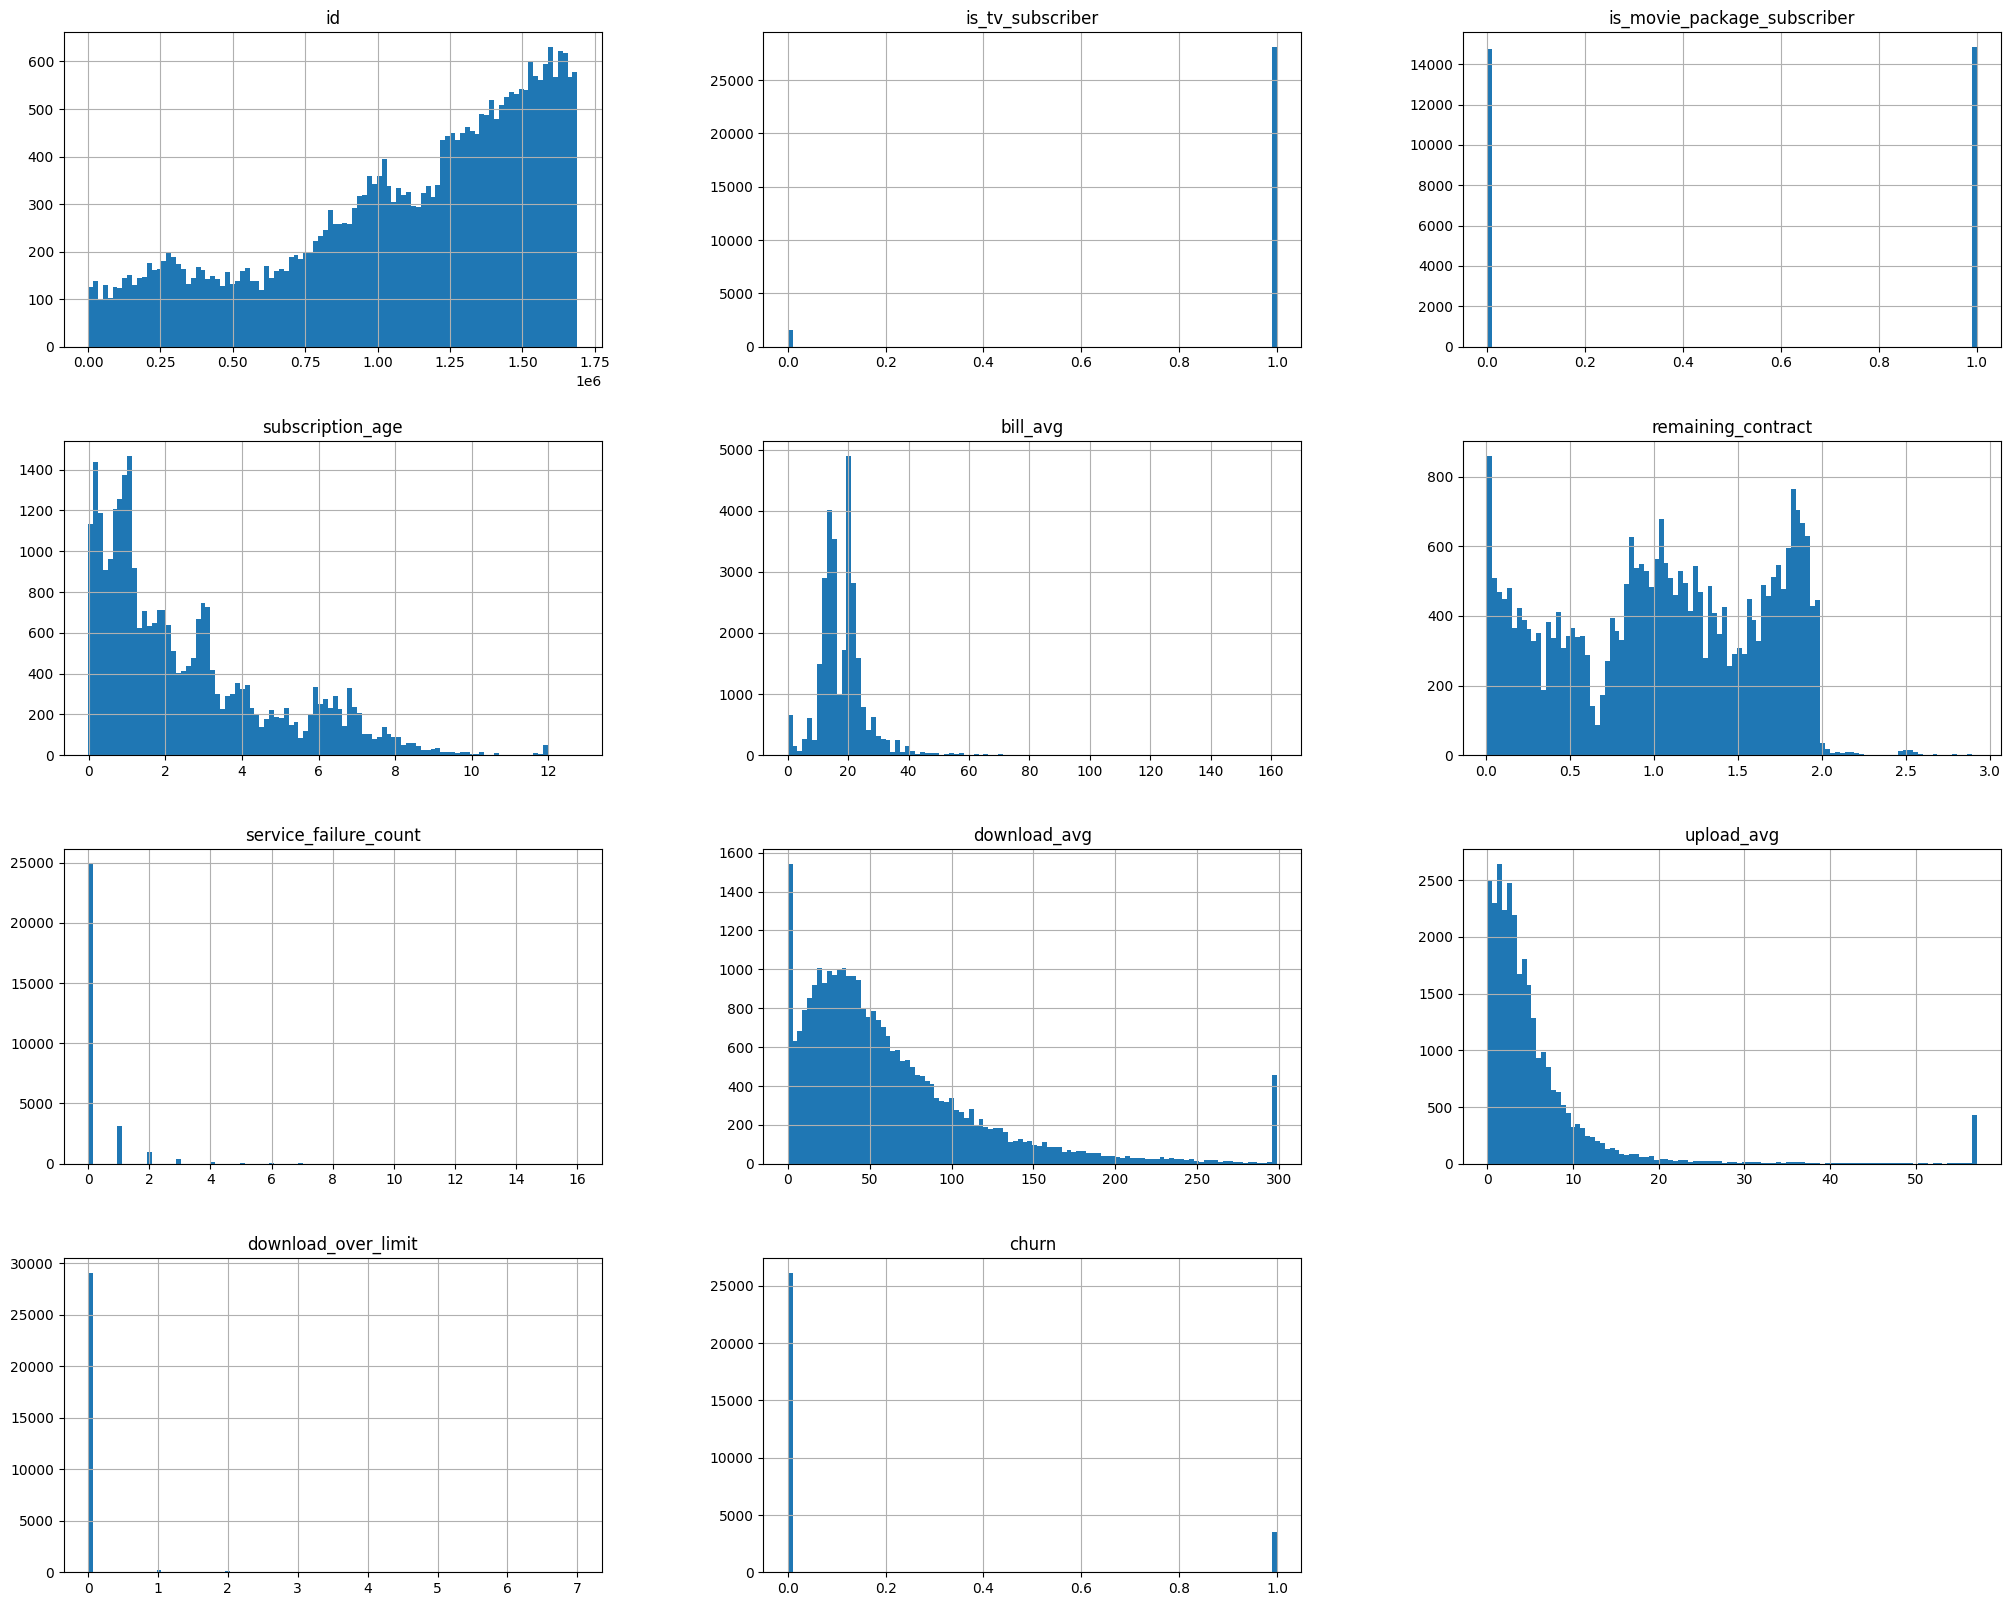

In [ ]:
df_subs_rc[1].hist(bins=100, figsize=(25, 20))

[rys. 5. Histogramy dla podzbioru próbek z wartością rc > 0]

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'is_tv_subscriber'}>,
        <Axes: title={'center': 'is_movie_package_subscriber'}>],
       [<Axes: title={'center': 'subscription_age'}>,
        <Axes: title={'center': 'bill_avg'}>,
        <Axes: title={'center': 'remaining_contract'}>],
       [<Axes: title={'center': 'service_failure_count'}>,
        <Axes: title={'center': 'download_avg'}>,
        <Axes: title={'center': 'upload_avg'}>],
       [<Axes: title={'center': 'download_over_limit'}>,
        <Axes: title={'center': 'churn'}>, <Axes: >]], dtype=object)

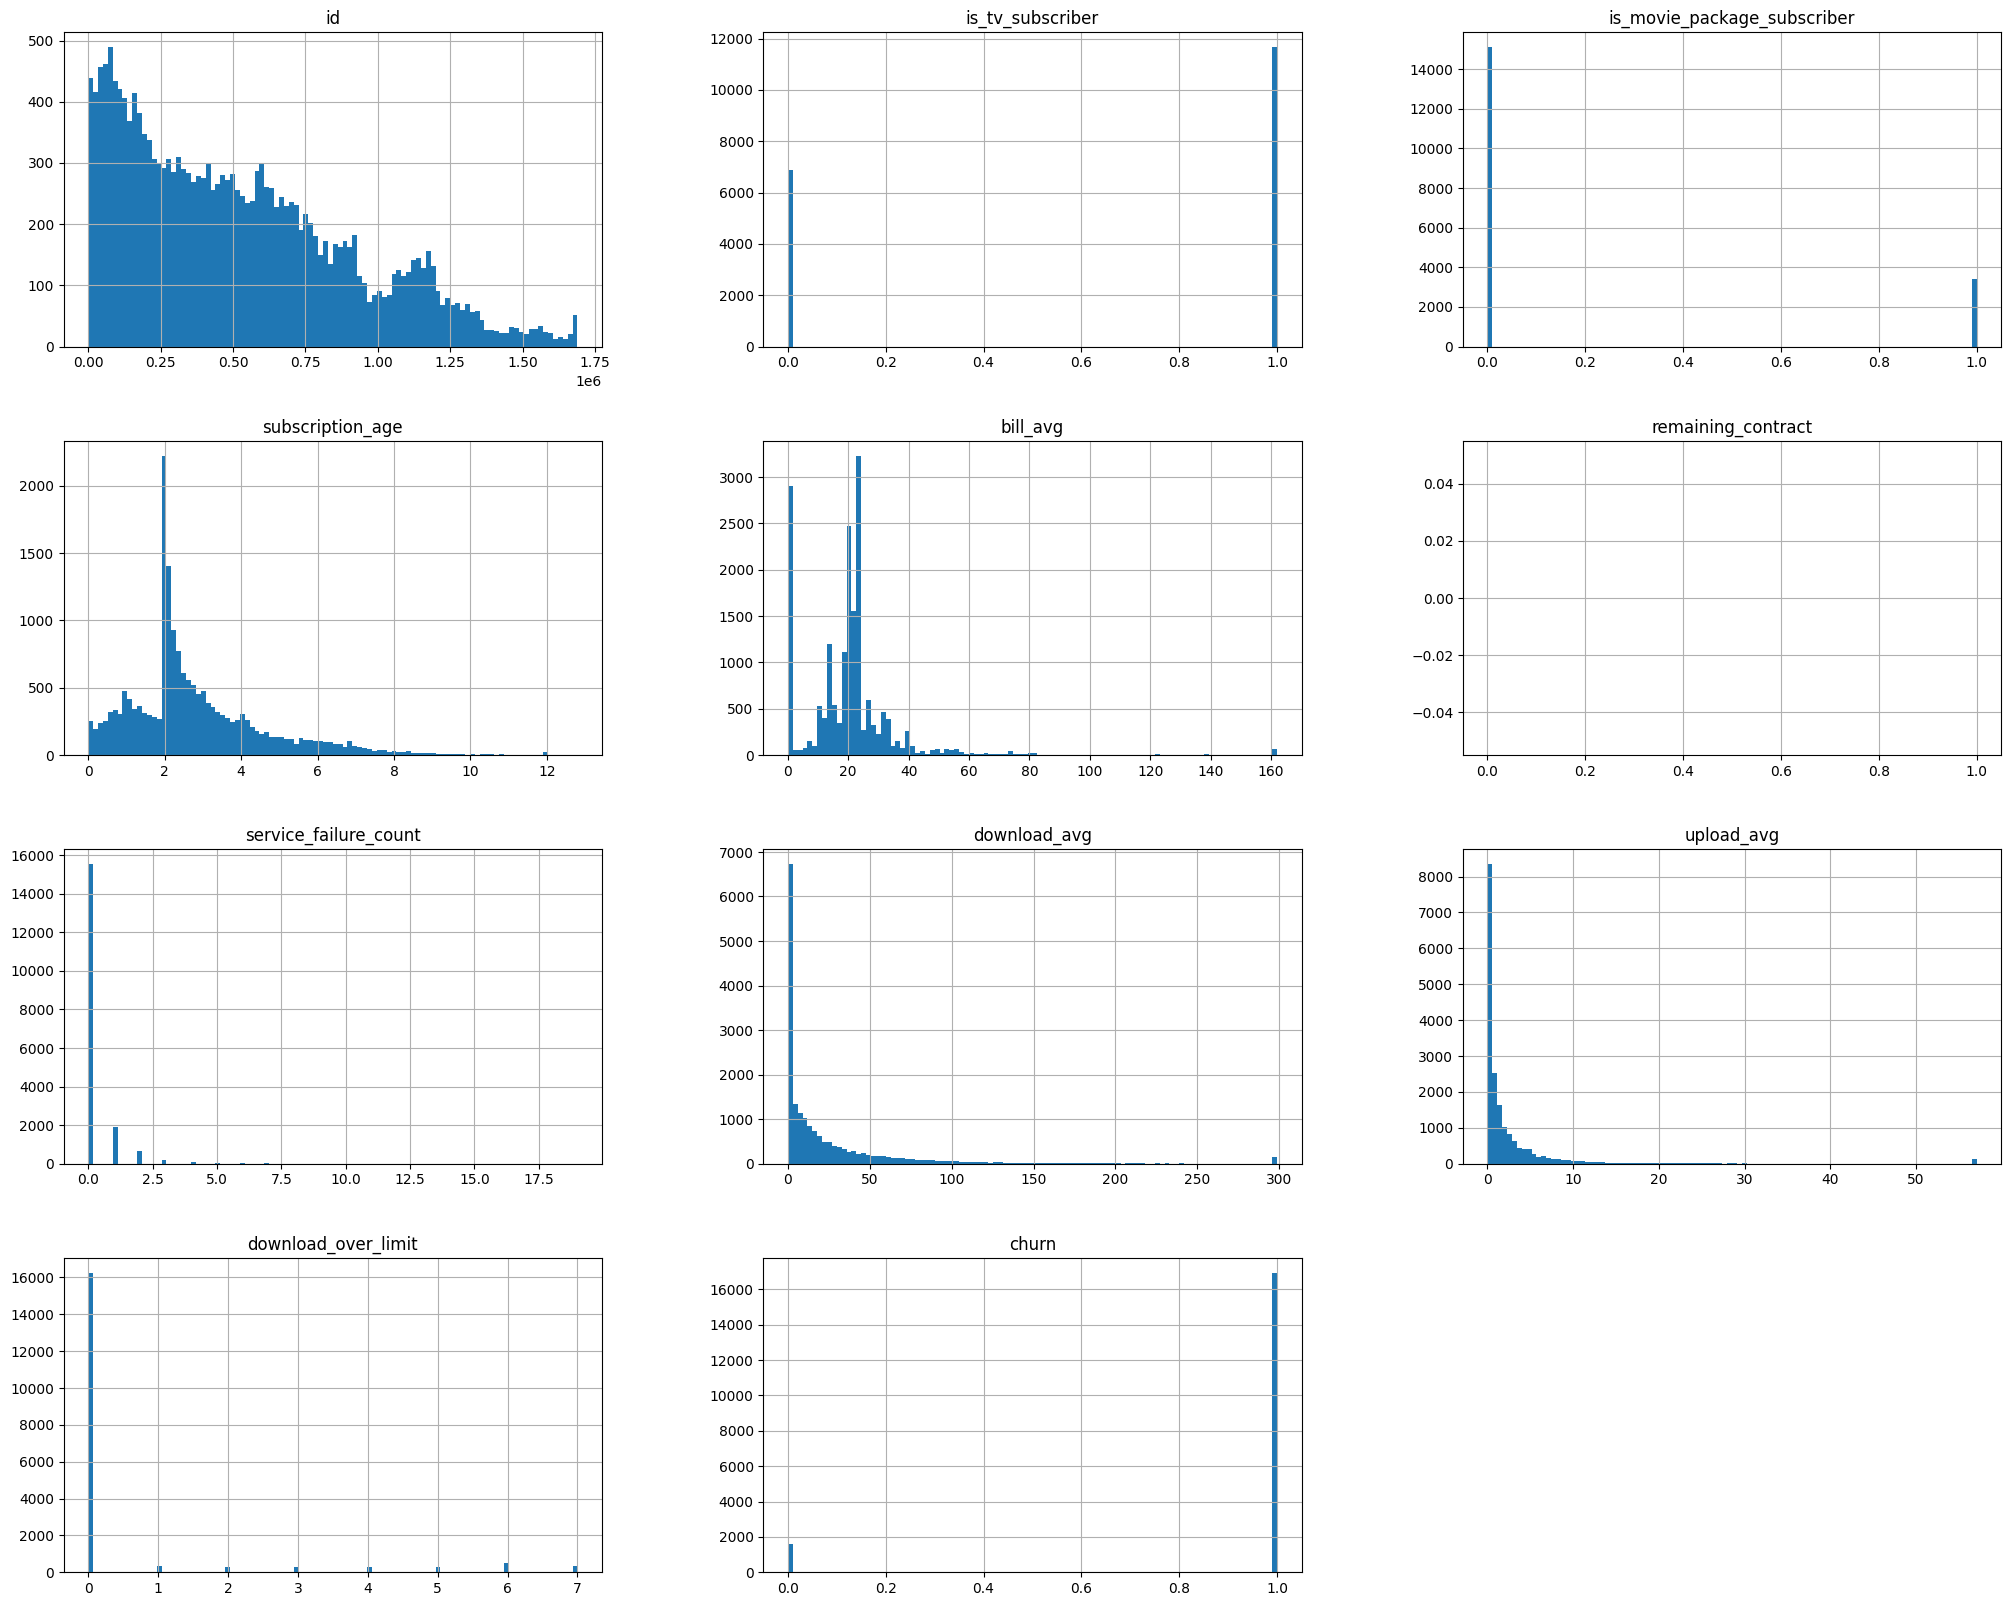

In [ ]:
df_subs_rc[2].hist(bins=100, figsize=(25, 20))

[rys. 6. Histogramy dla podzbioru próbek z wartością rc = NaN]

In [ ]:
NaN_df = df_subs_rc[2].fillna(0)
NaN_df.head()

id  is_tv_subscriber  is_movie_package_subscriber  subscription_age  \
1  18                 0                            0              8.22   
3  27                 0                            0              6.87   
4  34                 0                            0              6.39   
7  84                 0                            0              5.48   
8  94                 0                            0              8.54   

   bill_avg  remaining_contract  service_failure_count  download_avg  \
1         0                 0.0                      0           0.0   
3        21                 0.0                      1           0.0   
4         0                 0.0                      0           0.0   
7        14                 0.0                      1           0.0   
8         0                 0.0                      0           0.0   

   upload_avg  download_over_limit  churn  
1         0.0                    0      1  
3         0.0                    0      1  
4         0.0                    0      1  
7         0.0                    0      1  
8         0.0                    0      1

In [ ]:
NaN_df.describe()

id  is_tv_subscriber  is_movie_package_subscriber  \
count  1.852400e+04      18524.000000                 18524.000000   
mean   5.166042e+05          0.629562                     0.184679   
std    3.885046e+05          0.482935                     0.388048   
min    1.800000e+01          0.000000                     0.000000   
25%    1.830992e+05          0.000000                     0.000000   
50%    4.488405e+05          1.000000                     0.000000   
75%    7.611372e+05          1.000000                     0.000000   
max    1.689600e+06          1.000000                     1.000000   

       subscription_age      bill_avg  remaining_contract  \
count      18524.000000  18524.000000             18524.0   
mean           2.808802     20.383071                 0.0   
std            1.807481     16.582718                 0.0   
min            0.000000      0.000000                 0.0   
25%            1.900000     13.000000                 0.0   
50%            2.320000     21.000000                 0.0   
75%            3.550000     24.000000                 0.0   
max           12.800000    162.000000                 0.0   

       service_failure_count  download_avg    upload_avg  download_over_limit  \
count            18524.00000  18524.000000  18524.000000         18524.000000   
mean                 0.27548     25.156921      2.656219             0.518948   
std                  0.84165     43.295572      6.509631             1.562710   
min                  0.00000      0.000000      0.000000             0.000000   
25%                  0.00000      0.000000      0.000000             0.000000   
50%                  0.00000      9.100000      0.700000             0.000000   
75%                  0.00000     30.525000      2.500000             0.000000   
max                 19.00000    298.700000     57.100000             7.000000   

              churn  
count  18524.000000  
mean       0.913518  
std        0.281083  
min        0.000000  
25%        1.000000  
50%        1.000000  
75%        1.000000  
max        1.000000

In [ ]:
# Podział NaN_df, czyli tego bez standaryzacji i ze wszystkimi kolumami
bool_vecs_NaN_ch = {
    "ch == 0": NaN_df[ch] == 0,
    "ch == 1": NaN_df[ch] == 1,
}

sub_NaNs_ch = fns.create_subdfs_list(NaN_df, bool_vecs_NaN_ch)

(1602, 11)
(16922, 11)


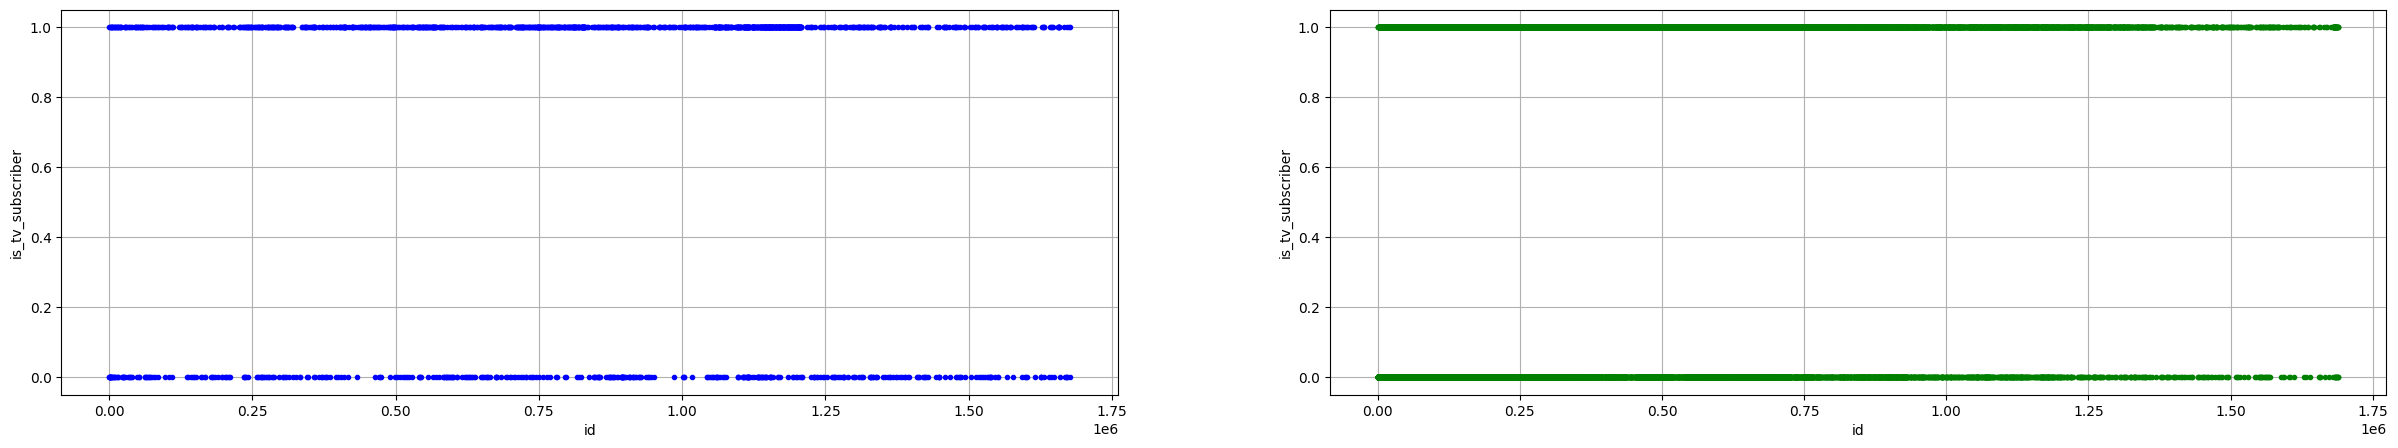

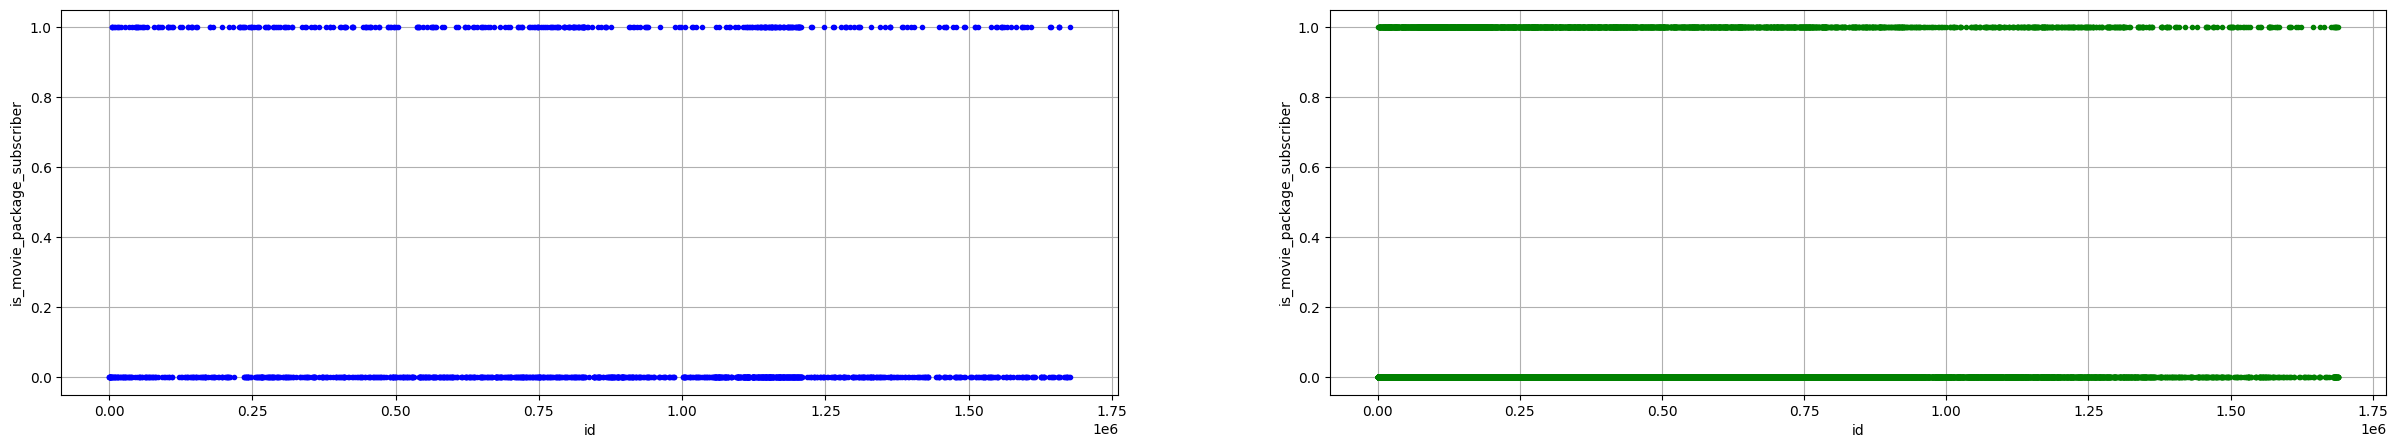

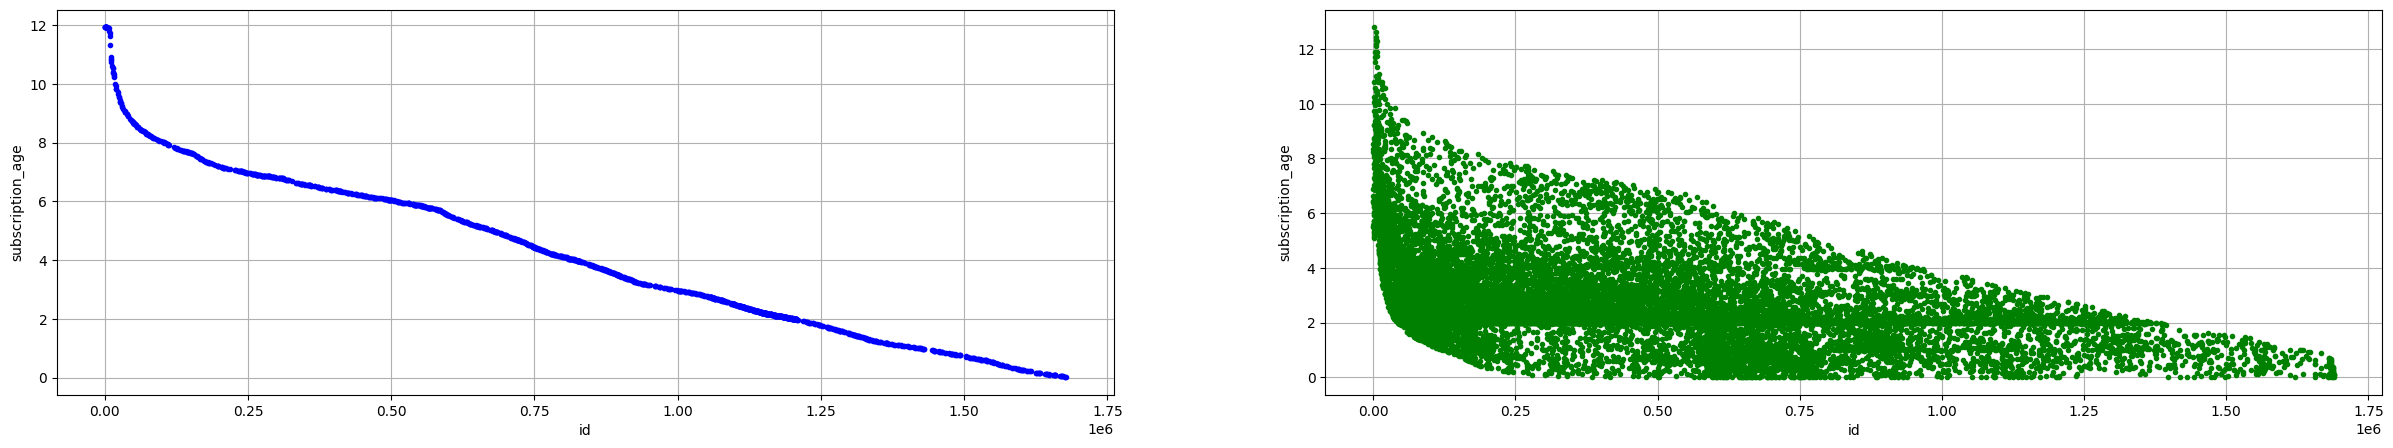

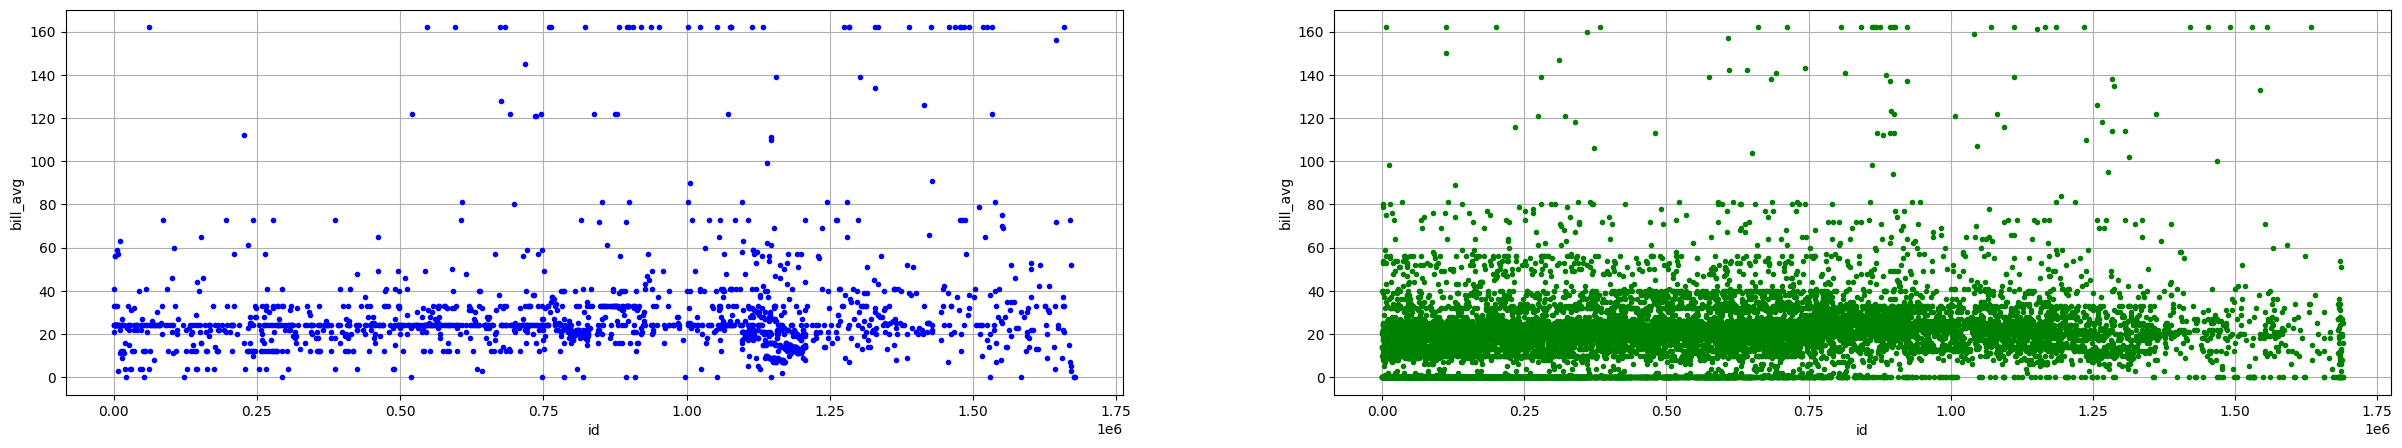

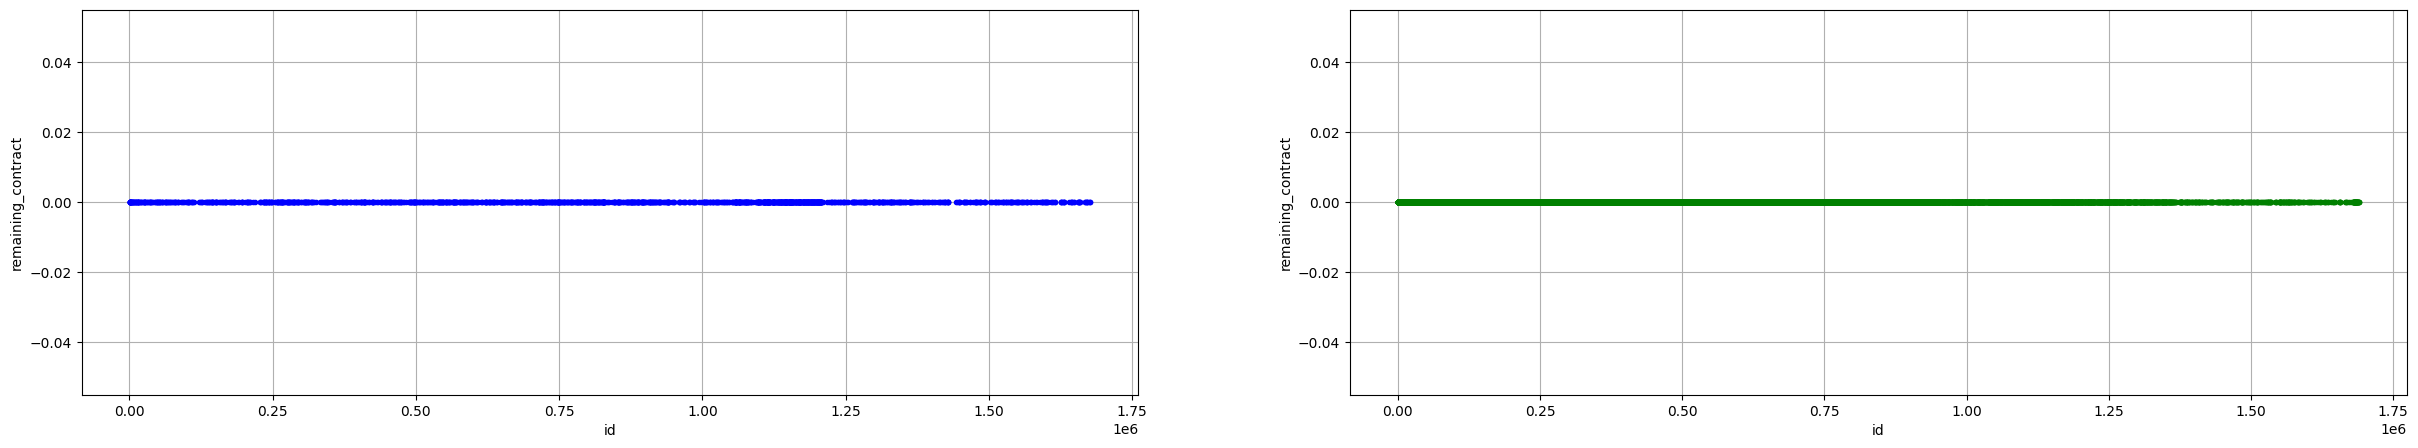

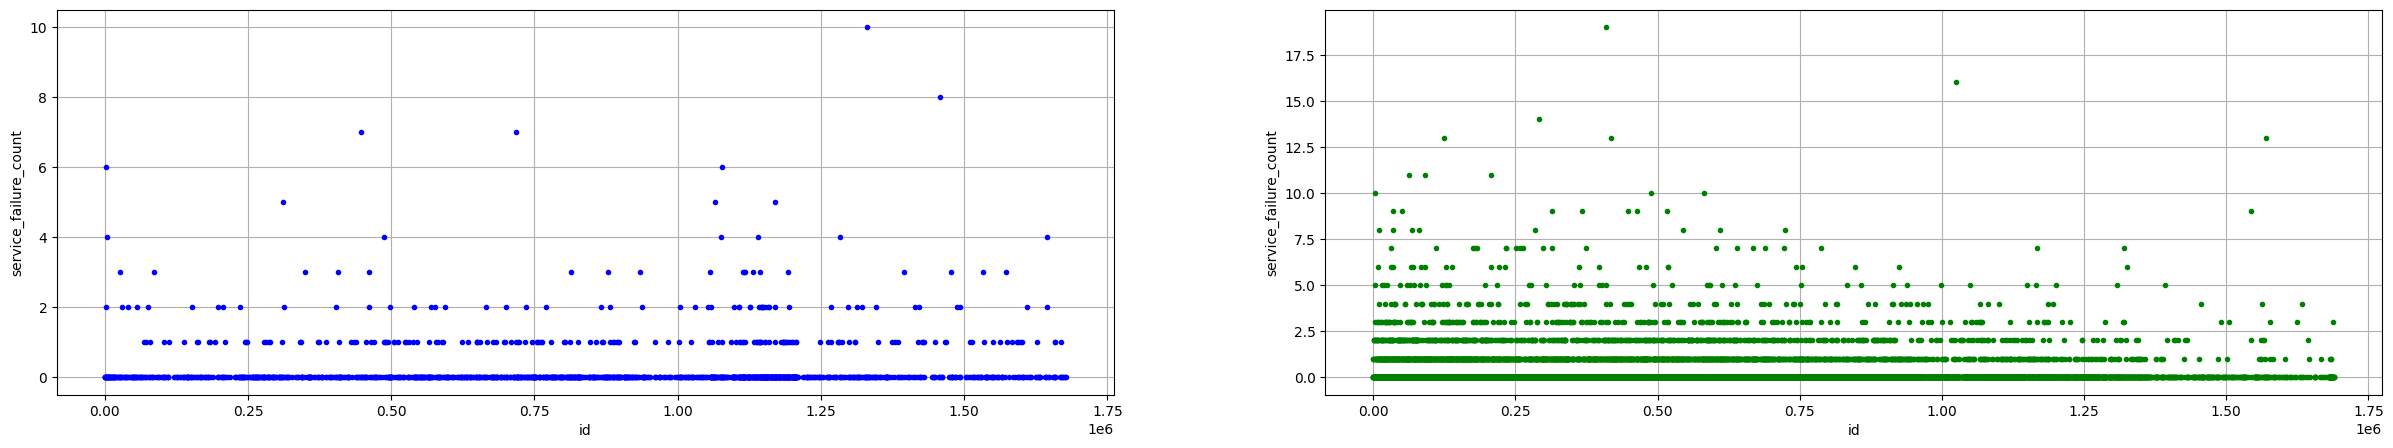

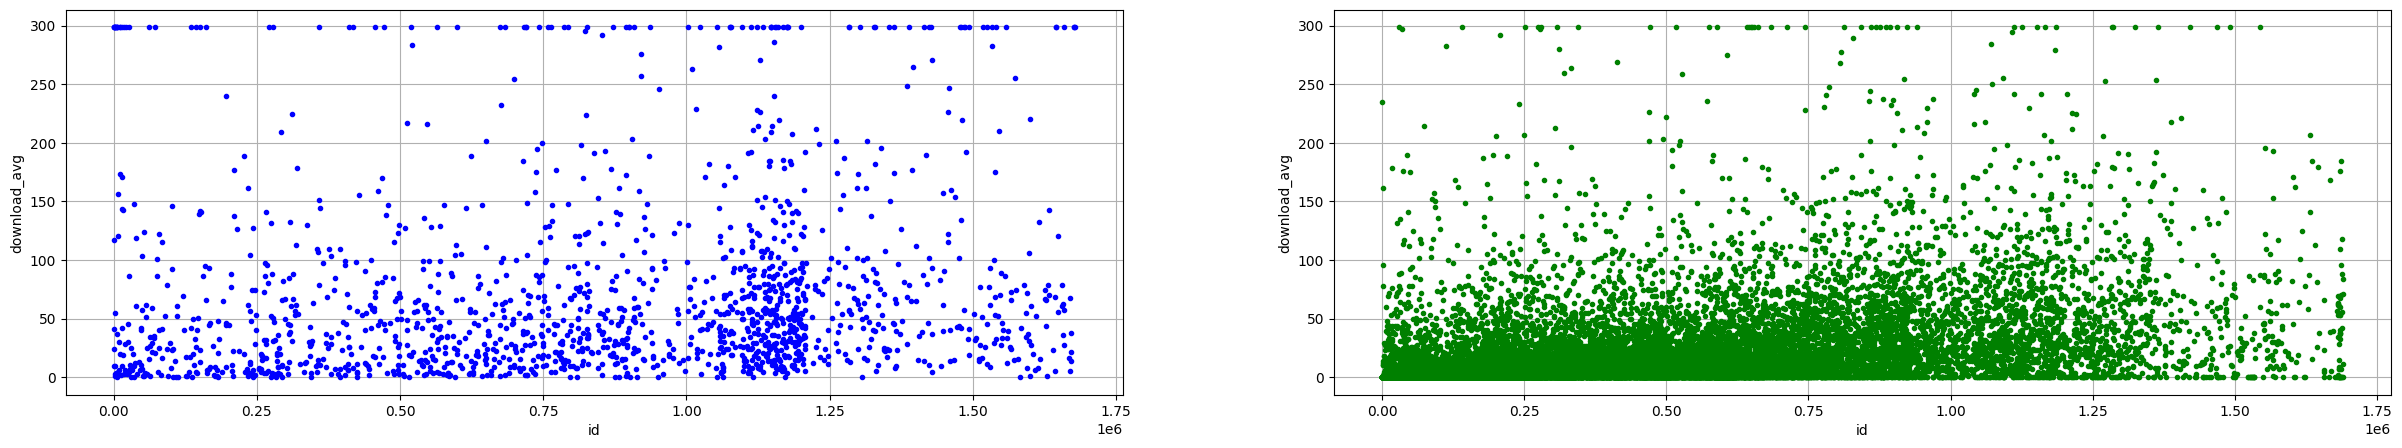

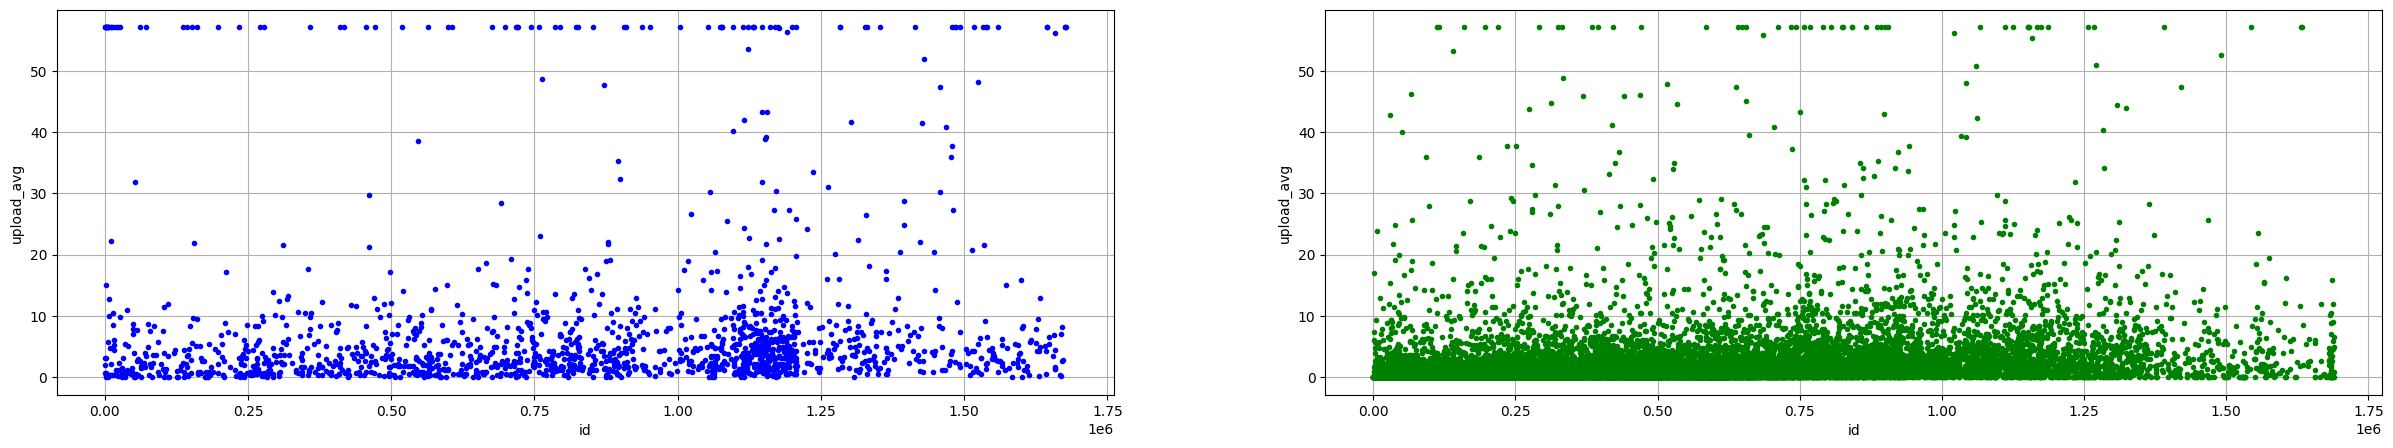

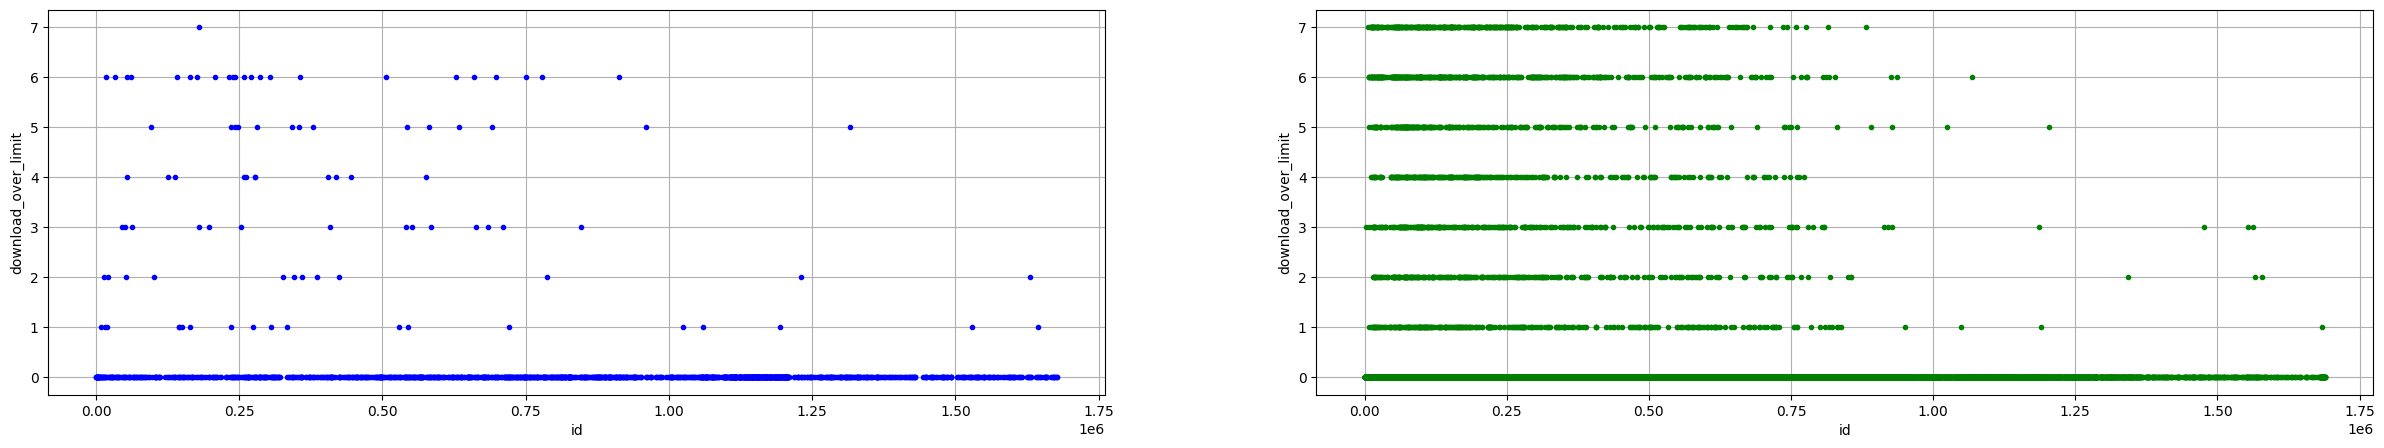

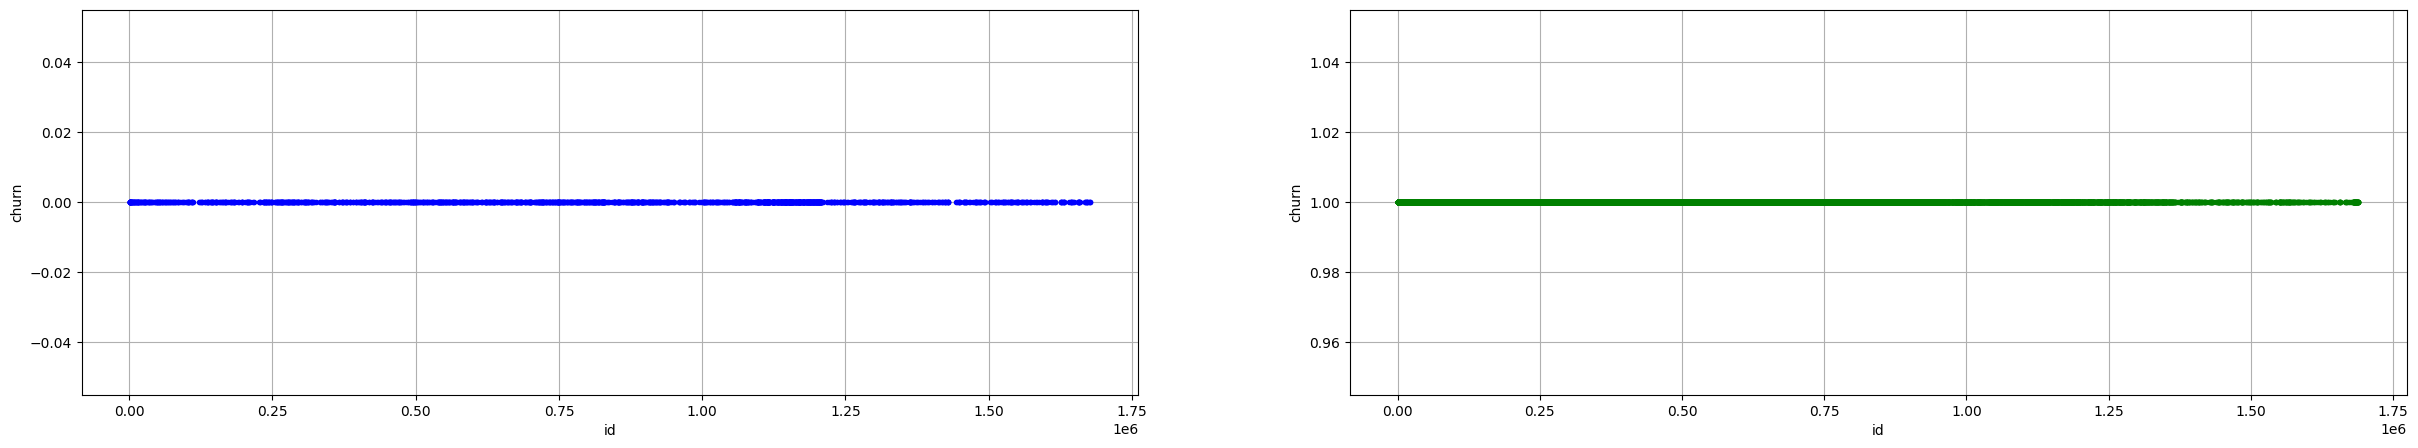

In [ ]:
fns.sample_by_sample_comparison(sub_NaNs_ch, sub_NaNs_ch[0].columns[1:])

[rys. 7. rc = NaN. Zestawienia wykresów wartości cech poszczególnych próbek dla ch=0 (po lewej) oraz ch=1 (po prawej) ]

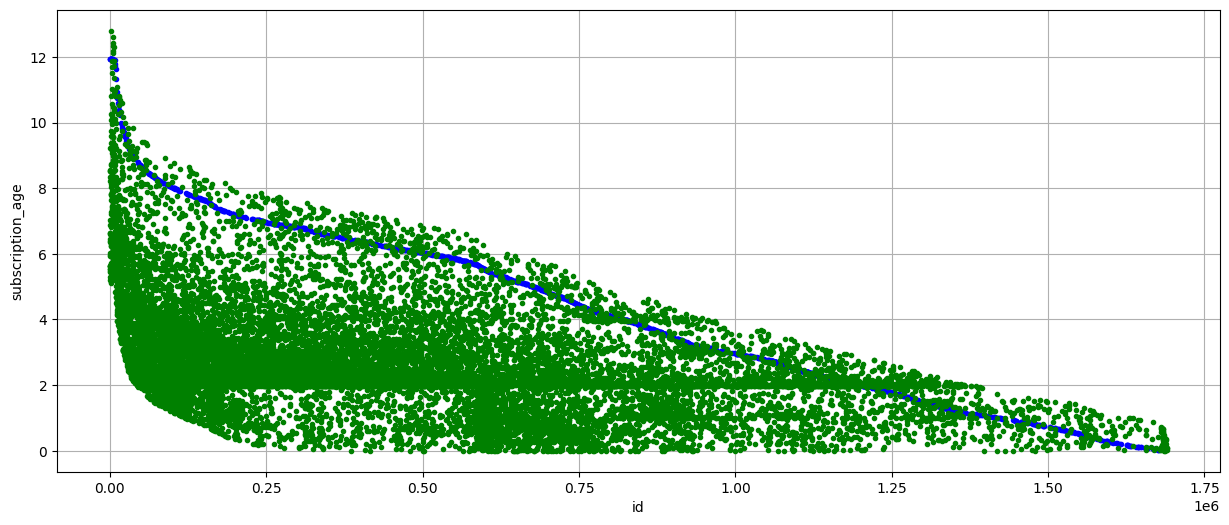

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(sub_NaNs_ch[0]["id"], sub_NaNs_ch[0]["subscription_age"], "b.", sub_NaNs_ch[1]["id"], sub_NaNs_ch[1]["subscription_age"], "g.")
plt.xlabel("id")
plt.ylabel("subscription_age")
plt.grid(True)
plt.show()

[rys. 8. rc = NaN. Nałożenie wykresów wartości cechy sa poszczególnych próbek dla ch=0 (niebieski) oraz ch=1 (zielony) ]

Niebieska linia będąca wykresem malejącej zalieżności pomiędzy id, a wiekiem subskrypcji dla aktywnych klientów, ewidentnie wskazuje na to, że numery id są nadawane klientom po kolei. Im wyższe id, tym mniejszy wiek subskrypcji. Zatem w numerze id jest zakodowany czas, jaki upłynął od momentu zakupienia usługi do "teraz". Mając zatem kombinację cech id i sa, można przewidzieć, co jest wpisane w kolumnie "churn" (jeżeli czas od zakupienia = wiek subskrypcji to ch = 0 - klient dalej z nami jest) ale nie daje to żadnej informacji na temat potencjalnej przyszłej rezygnacji. W kontekścia rozwiązania problemu przyszłej rezygnacji, należy więc conajmniej jedną z tych cech (id, sa) wykluczyć.

Dygresja. Wcześniej próbując zbudować model na wszystkich próbkach z usunięciem jedynie kolumny rc, zauważyłam, że model taki prawie się nie myli w przypadku próbek z ch = 0 (niebieskie), natomiast czasem się myli w przypadku ch = 1 (prawdopodobnie te mylone to leżące blisko niebieskiej linii). Długo nie mogłam wytłumaczyć, dlaczego tak jest. W końcu wpadłam na to, że odpowiedzią jest właśnie to, że jeżeli czas od zakupienia = wiek subskrypcji to ch = 0

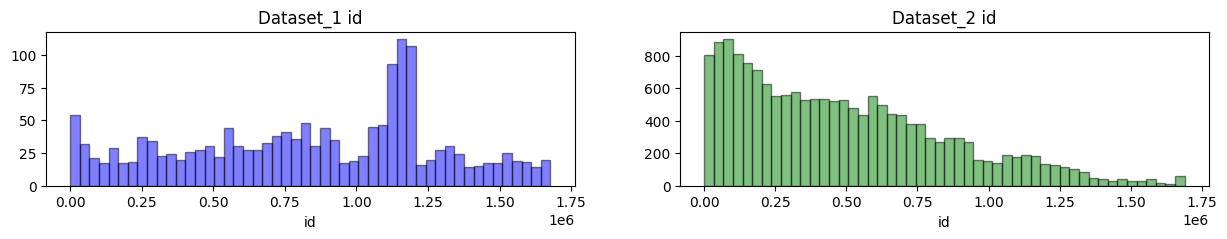

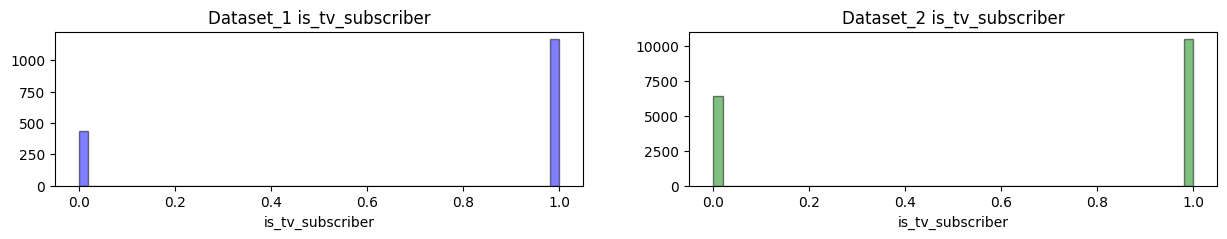

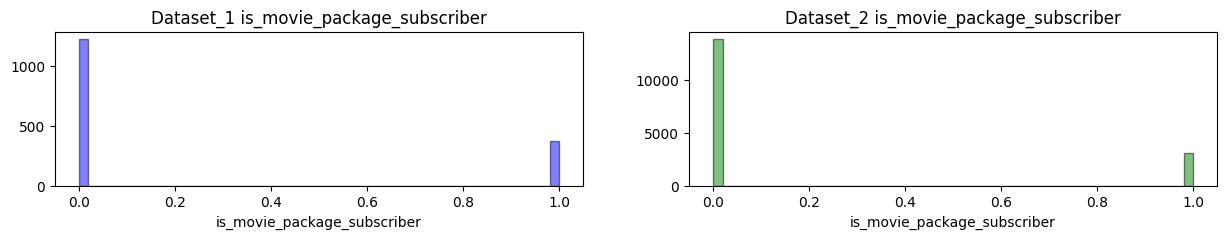

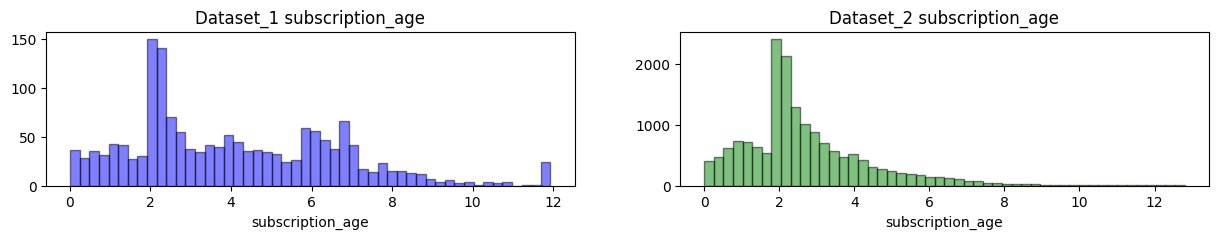

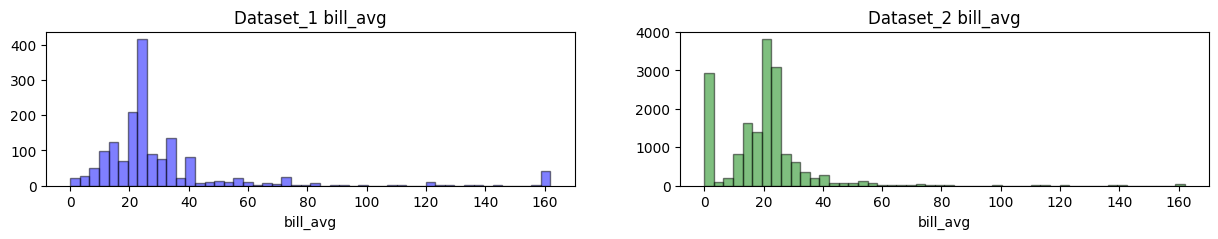

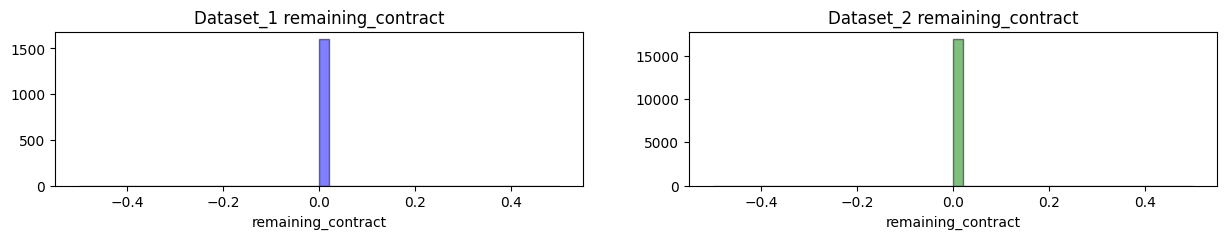

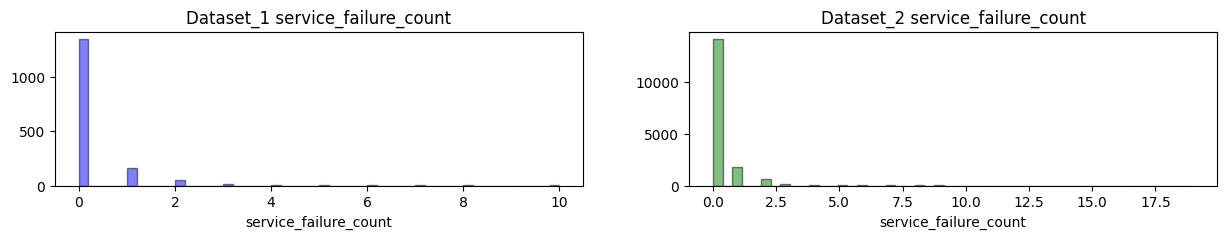

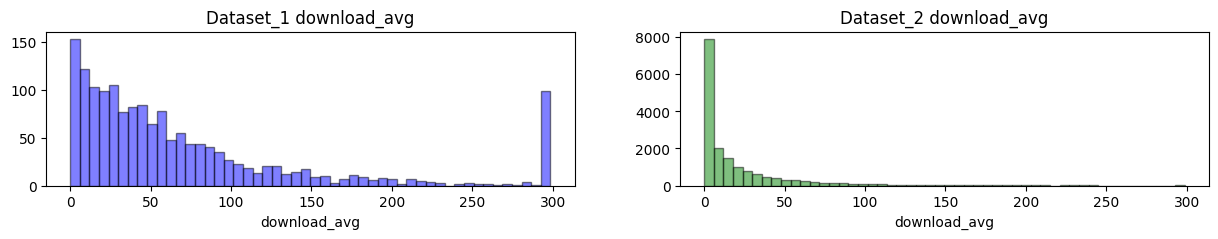

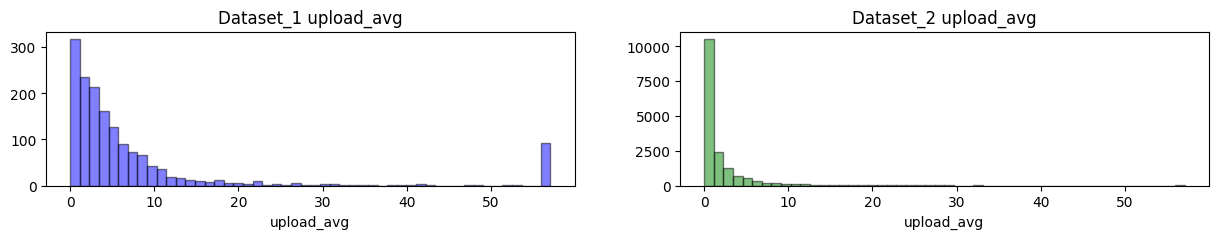

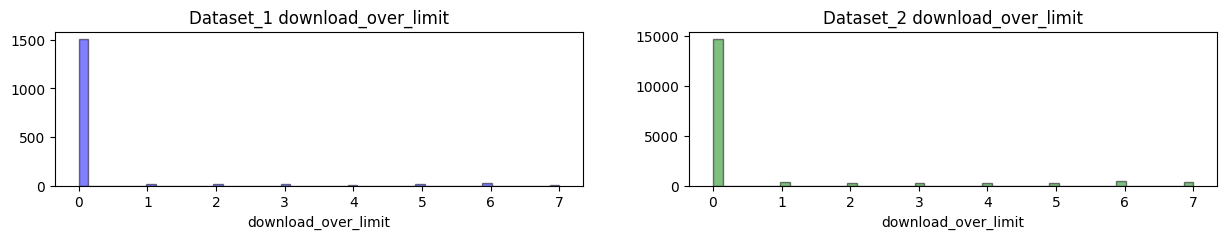

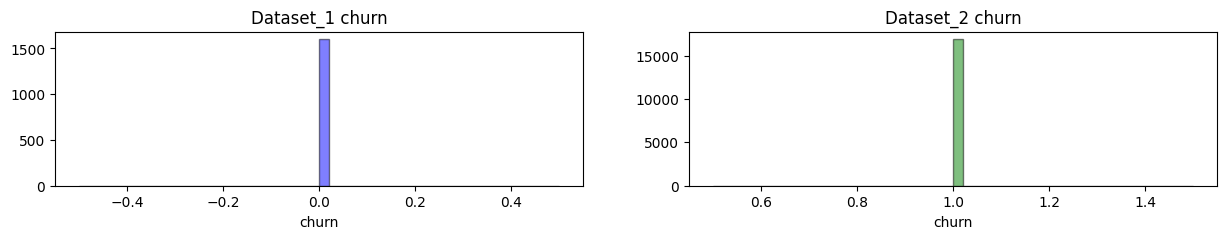

In [ ]:
fns.hist_comparison(sub_NaNs_ch[0],sub_NaNs_ch[1])

[rys. 9. rc = NaN. Zestawienia histogramów dla ch=0 (po lewej) oraz ch=1 (po prawej) ]

Spostrzeżenie (rys. 8, bill_avg po prawej): są klienci, którzy zrezygnowali z usługi bez zapłacenia żadnego rachunki. Nie korzystali z serwisu?

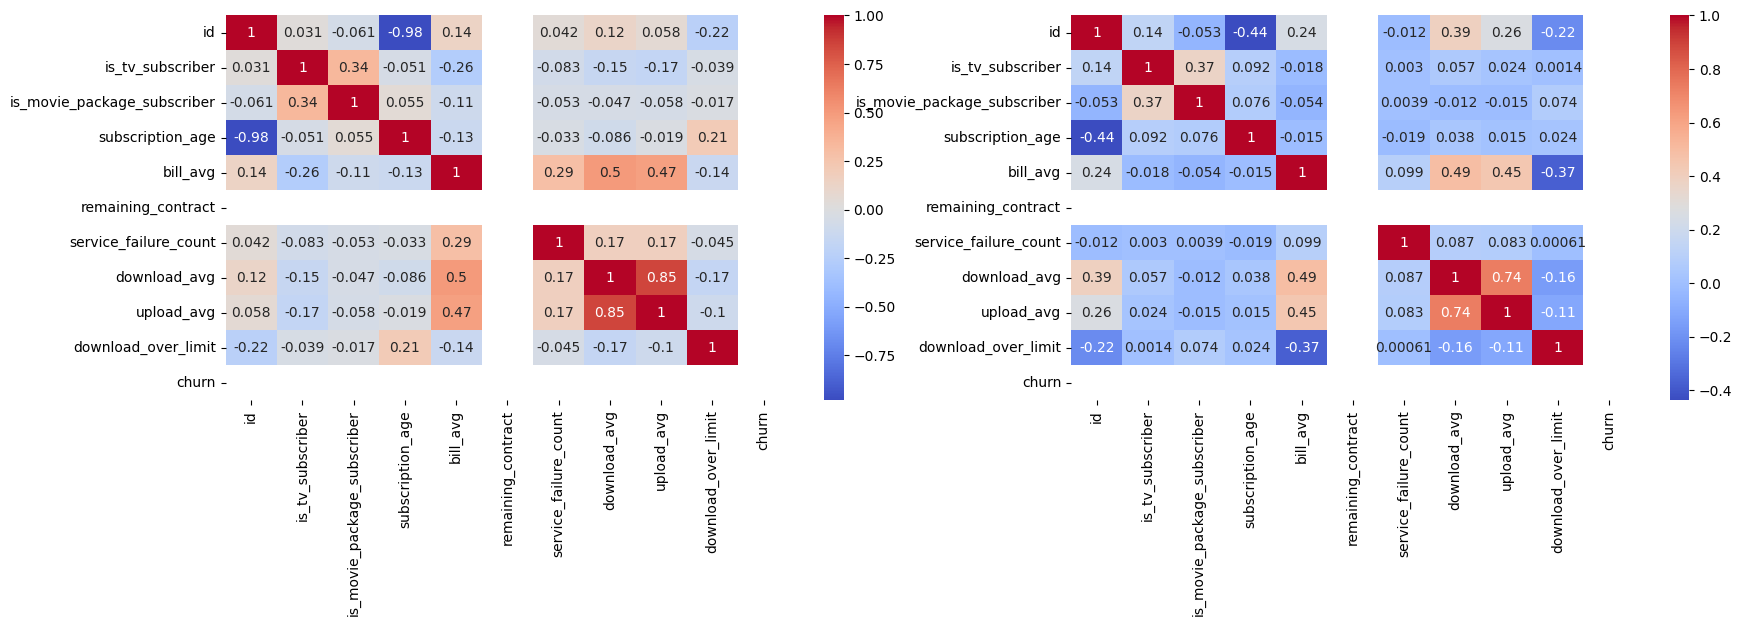

In [ ]:
fns.corr_comparison(sub_NaNs_ch[0], sub_NaNs_ch[1])

[rys. 9. rc = NaN. Zestawienia macierzy korelacji dla ch=0 (po lewej) oraz ch=1 (po prawej) ]

W pierwszym kroku próbuję zbudować model bez czyszczenia datasetu, mimo, że przewiduję, że w ten sposób nie osiągnę sensownych rezultatów.
ch=1 jest 10 razy więcej niż ch=0;
występują outlayery (rys. 7 oraz rys. 8 - zasięg histogramów)

Dokonuję standaryzacji w komunach wejściowych i sprawdzam efekt. Oczekuję, że mean = 0 i std = 1

In [ ]:
NaN_df_std = std_machine(NaN_df)
NaN_df_std.describe()

id  is_tv_subscriber  is_movie_package_subscriber  \
count  1.852400e+04      1.852400e+04                 1.852400e+04   
mean  -9.819636e-17      2.454909e-17                -3.797437e-17   
std    1.000027e+00      1.000027e+00                 1.000027e+00   
min   -1.329714e+00     -1.303650e+00                -4.759320e-01   
25%   -8.584556e-01     -1.303650e+00                -4.759320e-01   
50%   -1.744266e-01      7.670768e-01                -4.759320e-01   
75%    6.294382e-01      7.670768e-01                -4.759320e-01   
max    3.019340e+00      7.670768e-01                 2.101140e+00   

       subscription_age      bill_avg  remaining_contract  \
count      1.852400e+04  1.852400e+04             18524.0   
mean       6.137273e-17  6.137273e-18                 0.0   
std        1.000027e+00  1.000027e+00                 0.0   
min       -1.554029e+00 -1.229209e+00                 0.0   
25%       -5.028140e-01 -4.452388e-01                 0.0   
50%       -2.704401e-01  3.720416e-02                 0.0   
75%        4.100835e-01  2.181203e-01                 0.0   
max        5.527842e+00  8.540262e+00                 0.0   

       service_failure_count  download_avg    upload_avg  download_over_limit  \
count           1.852400e+04  1.852400e+04  18524.000000         1.852400e+04   
mean           -4.027585e-17  1.227455e-17      0.000000         7.364727e-17   
std             1.000027e+00  1.000027e+00      1.000027         1.000027e+00   
min            -3.273189e-01 -5.810663e-01     -0.408055        -3.320912e-01   
25%            -3.273189e-01 -5.810663e-01     -0.408055        -3.320912e-01   
50%            -3.273189e-01 -3.708775e-01     -0.300520        -3.320912e-01   
75%            -3.273189e-01  1.239901e-01     -0.023999        -3.320912e-01   
max             2.224800e+01  6.318209e+00      8.363800         4.147426e+00   

              churn  
count  18524.000000  
mean       0.913518  
std        0.281083  
min        0.000000  
25%        1.000000  
50%        1.000000  
75%        1.000000  
max        1.000000



---


**PODEJŚCIE 1 - trenuję na wszystkich próbkach, gdzie rc = NaN (91% churn=1)**

Modele z "id" i "rc" trenuję tylko jako modele kontrolne, gdyż wiem, że one powinny dawać wysokie wyniki. W razie obniżenia ich rezultatów, będę przypuszczać zbyt mocne okrojenie datasetu. We właściwym modelu "id" musi być usunięte, gdyż sama kombinacja id i sa daje możliwość przewidzenia, co jest w kolumnie "churn", a nie chodzi o przewidywanie, co jest w kolumnie churn, tylko wyłapanie klientów, którzy będą chcieli zrezygnować z usług. Podobnie jest z kolumną "rc"

Modele 0 i 1 są modelami zgadującymi, co jest wpisane w kolumnie "churn". Modele 2 i 3 mają poszukiwać przyczyn odchodzenia przez klientów i przewidywać, czy dany klient odejdzie, np jak mu się skończy umowa.

In [ ]:
def models_machine(df: pd.DataFrame, test_size = 0.2):


  X, y = Xy_split(shuffle(df))

  #poly = PolynomialFeatures(degree=2)
  #X = poly.fit_transform(X)
  print(X.shape)

  model_log_reg = LogisticRegression( random_state=1, solver='lbfgs', max_iter = 500)


  model_svm = svm.SVC(C=1, kernel='rbf')


  model_ran_for = RandomForestClassifier(n_estimators=30, criterion='entropy', max_depth=8, random_state=13)


  model_xgb = XGBClassifier(random_state=13)



  models = {
            'lr': model_log_reg,
            'svm': model_svm,
            'rf': model_ran_for,
            'xgb': model_xgb
            }


  for value in models.values():
    value.fit(X, y)


  for key, value in models.items():
    print(key)
    scores = cross_val_score(value, X, y, cv=6, scoring='accuracy')
    print(f"cross validation accuracy mean = {scores.mean()}")

    value.fit(X, y)
    print(f"score = {value.score(X, y)}")



  return models

In [ ]:
models_0 = models_machine(NaN_df_std[[id, sa, ch]])

(18524, 2)
lr
cross validation accuracy mean = 0.8934894954774409
score = 0.8935974951414382
svm
cross validation accuracy mean = 0.9140575127575499
score = 0.9141654070395163
rf
cross validation accuracy mean = 0.9524397852322934
score = 0.9683113798315699
xgb
cross validation accuracy mean = 0.9779741518698112
score = 0.9847225221334485


In [ ]:
models_1 = models_machine(NaN_df_std)

(18524, 10)
lr
cross validation accuracy mean = 0.9073634532355586
score = 0.9078492766141222
svm
cross validation accuracy mean = 0.9190238621149587
score = 0.9238285467501619
rf
cross validation accuracy mean = 0.9250159836531043
score = 0.9334377024400777
xgb
cross validation accuracy mean = 0.9651805505901678
score = 0.9954653422586914


In [ ]:
models_2 = models_machine(NaN_df_std.drop(columns=[id, rc]))

(18524, 8)
lr
cross validation accuracy mean = 0.9162709917012286
score = 0.9162167998272511
svm
cross validation accuracy mean = 0.916000955032889
score = 0.9195638091125027
rf
cross validation accuracy mean = 0.9192399963521883
score = 0.9251241632476787
xgb
cross validation accuracy mean = 0.9203736782977029
score = 0.9612934571366876


In [ ]:
models_3 = models_machine(NaN_df_std.drop(columns=[id, rc, sa]))

(18524, 7)
lr
cross validation accuracy mean = 0.9156769110308818
score = 0.9157849276614122
svm
cross validation accuracy mean = 0.9158387581942885
score = 0.9180522565320665
rf
cross validation accuracy mean = 0.9162706070585154
score = 0.9187540488015548
xgb
cross validation accuracy mean = 0.9148673255386536
score = 0.942884906067804


Dla modelu budowanego na danych, w których 91% danych jest jedej kategorii, wynik 92% jest raczej niedobry ale sprawdzam wyniki z podziałem na churn = 0 i churn =1

In [ ]:
bool_vecs_NaN_std_ch = {
    "ch == 0": NaN_df_std[ch] == 0,
    "ch == 1": NaN_df_std[ch] == 1,
}

sub_NaNs_std_ch = fns.create_subdfs_list(NaN_df_std, bool_vecs_NaN_std_ch)

(1602, 11)
(16922, 11)


In [ ]:
for key, value in models_2.items():
  print(key)
  print(value.score(*Xy_split(sub_NaNs_std_ch[1].drop(columns=[id, rc]))) )


lr
0.9906630421935941
svm
0.9985226332584801
rf
0.9985226332584801
xgb
0.9962770358113698


In [ ]:
for key, value in models_2.items():
  print(key)
  print(value.score(*Xy_split(sub_NaNs_std_ch[0].drop(columns=[id, rc]))) )

lr
0.12983770287141075
svm
0.08551810237203496
rf
0.149812734082397
xgb
0.5917602996254682


Powyższe wyniki pokazują, że model prawie zawsze przewiduje 1, więc ma niemal 100% skuteczności dla próbek, dla których churn = 1 i blisko 0 dla churn = 0. Świadczy to o tym, że model jest do kitu

---



---


**PODEJŚCIE 2 - odrzucam część próbek, dla których rc=NaN i  ch=1, aby wyeliminować dysproporcję pomiędzy ch=1 i ch=0**

Dataset, na którym pracuję zawiera 18524 próbki, z czego 1602 próbki, czyli niecałe 10% ma wartość churn = 0. Spróbuję wyeliminować część próbek, dla których churn = 0, aby wyrównać tą dysproporcję. Wcześniej jeszcze wyeliminuję outlayerów.

Odchudzę dataset o większość próbek, dla których churn=1, aby wyrównać churny

In [ ]:
NaN_ch_0 = sub_NaNs_ch[0]
NaN_ch_1 = sub_NaNs_ch[1]

N = NaN_df.shape[0]

n = sub_NaNs_ch[0].shape[0]
print(n/N)

0.08648240120924207


In [ ]:
test_size = 0.9

NaN_ch_1.describe()

id  is_tv_subscriber  is_movie_package_subscriber  \
count  1.692200e+04      16922.000000                 16922.000000   
mean   4.860429e+05          0.620021                     0.180061   
std    3.688855e+05          0.485396                     0.384250   
min    1.800000e+01          0.000000                     0.000000   
25%    1.722840e+05          0.000000                     0.000000   
50%    4.184290e+05          1.000000                     0.000000   
75%    7.137258e+05          1.000000                     0.000000   
max    1.689600e+06          1.000000                     1.000000   

       subscription_age      bill_avg  remaining_contract  \
count      16922.000000  16922.000000             16922.0   
mean           2.688168     19.418272                 0.0   
std            1.669351     14.811016                 0.0   
min            0.000000      0.000000                 0.0   
25%            1.840000     13.000000                 0.0   
50%            2.270000     21.000000                 0.0   
75%            3.370000     24.000000                 0.0   
max           12.800000    162.000000                 0.0   

       service_failure_count  download_avg    upload_avg  download_over_limit  \
count           16922.000000  16922.000000  16922.000000         16922.000000   
mean                0.277154     20.686544      2.122361             0.547748   
std                 0.848076     35.265788      5.041844             1.604282   
min                 0.000000      0.000000      0.000000             0.000000   
25%                 0.000000      0.000000      0.000000             0.000000   
50%                 0.000000      7.400000      0.600000             0.000000   
75%                 0.000000     25.400000      2.100000             0.000000   
max                19.000000    298.700000     57.100000             7.000000   

         churn  
count  16922.0  
mean       1.0  
std        0.0  
min        1.0  
25%        1.0  
50%        1.0  
75%        1.0  
max        1.0

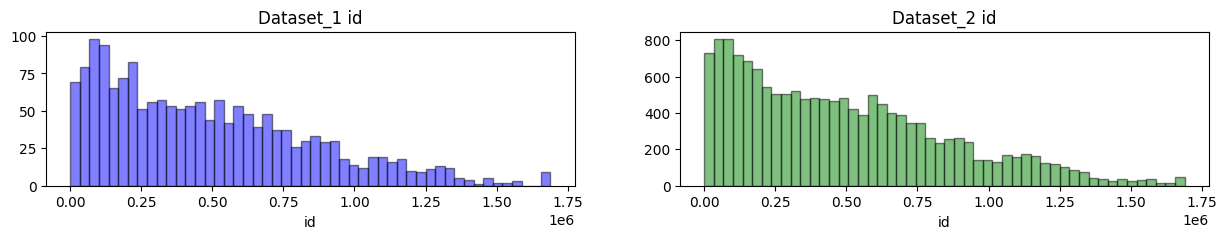

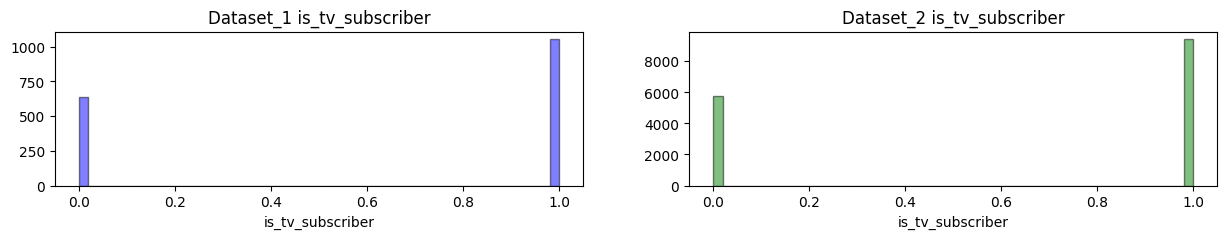

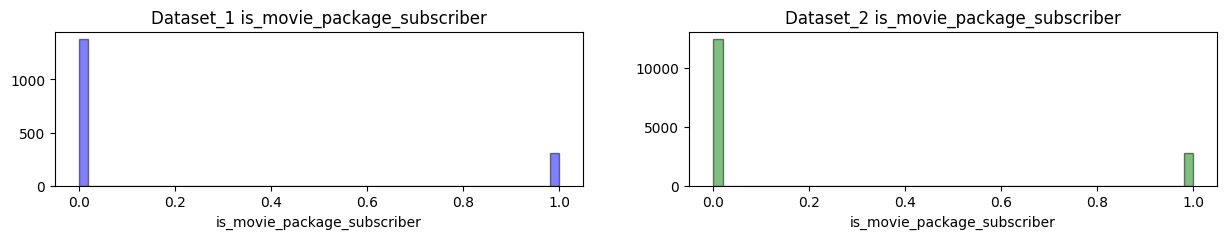

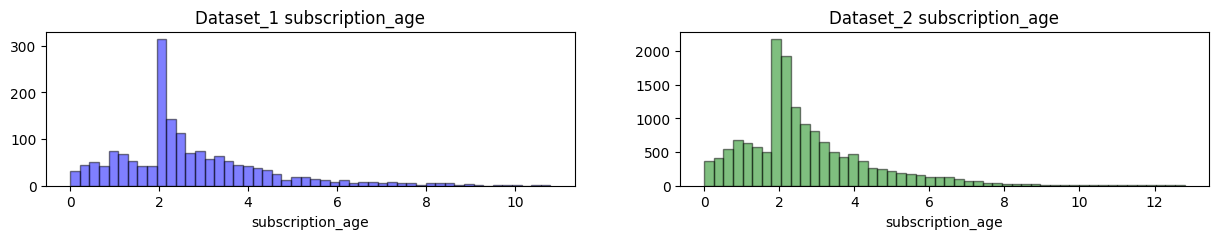

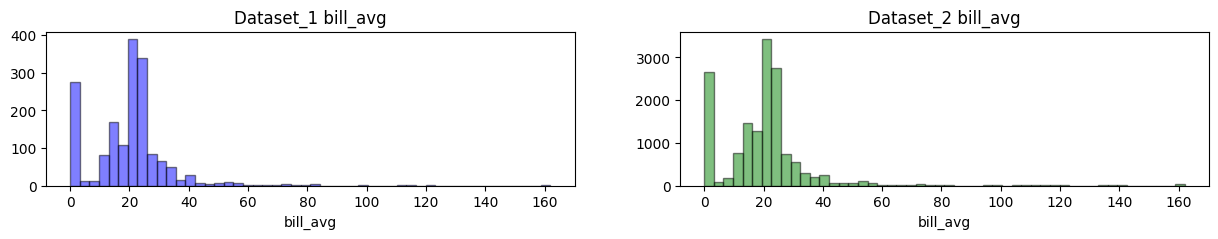

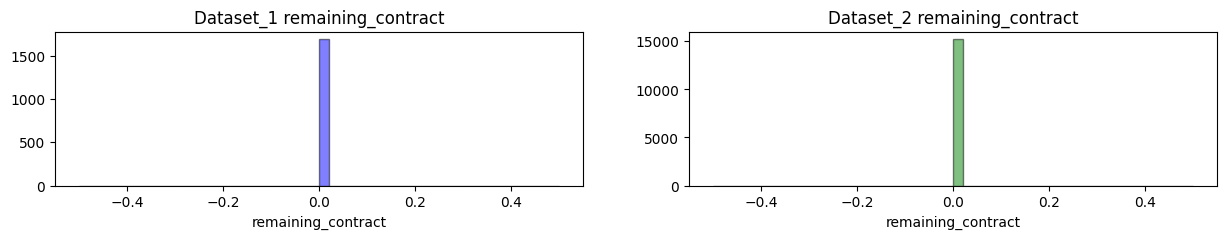

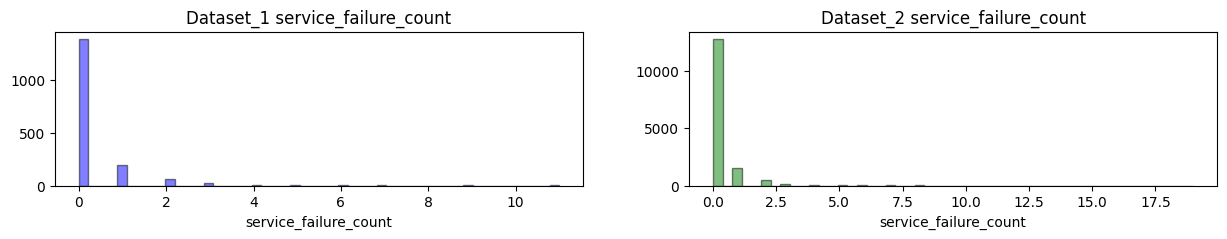

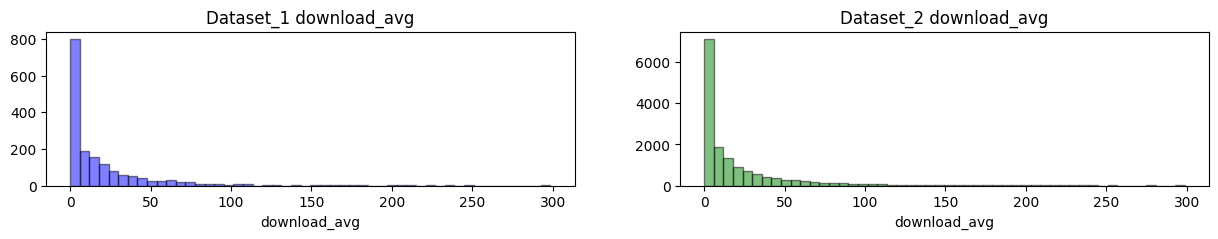

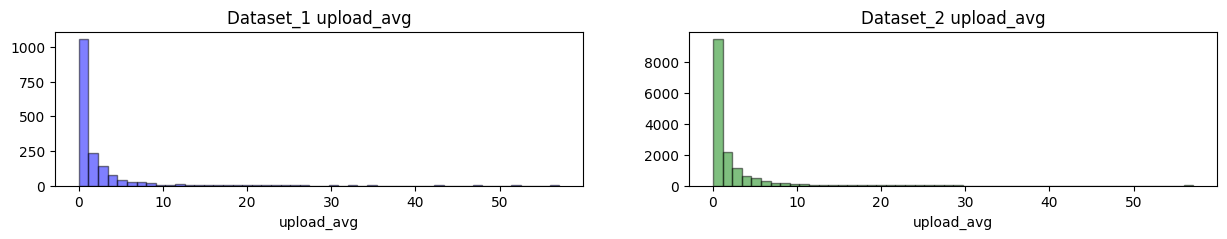

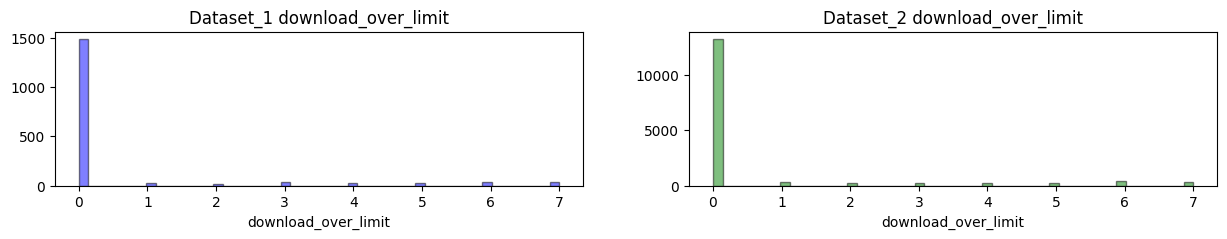

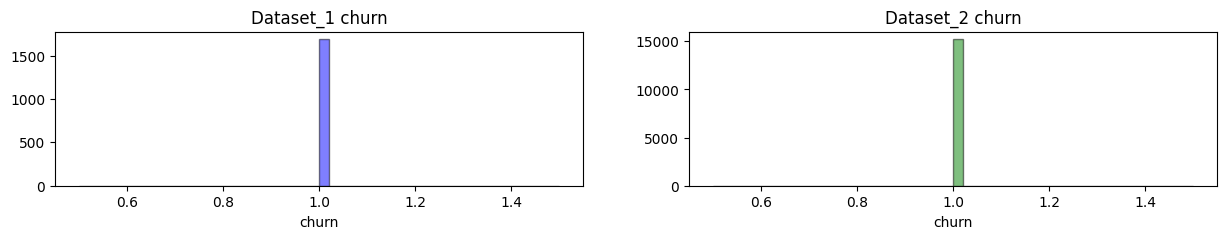

In [ ]:
if load_data == 0:
  steps = 0
  NaN_ch_1_train, NaN_ch_1_test = train_test_split(NaN_ch_1, test_size=test_size)
  fns.hist_comparison(NaN_ch_1_train, NaN_ch_1_test)

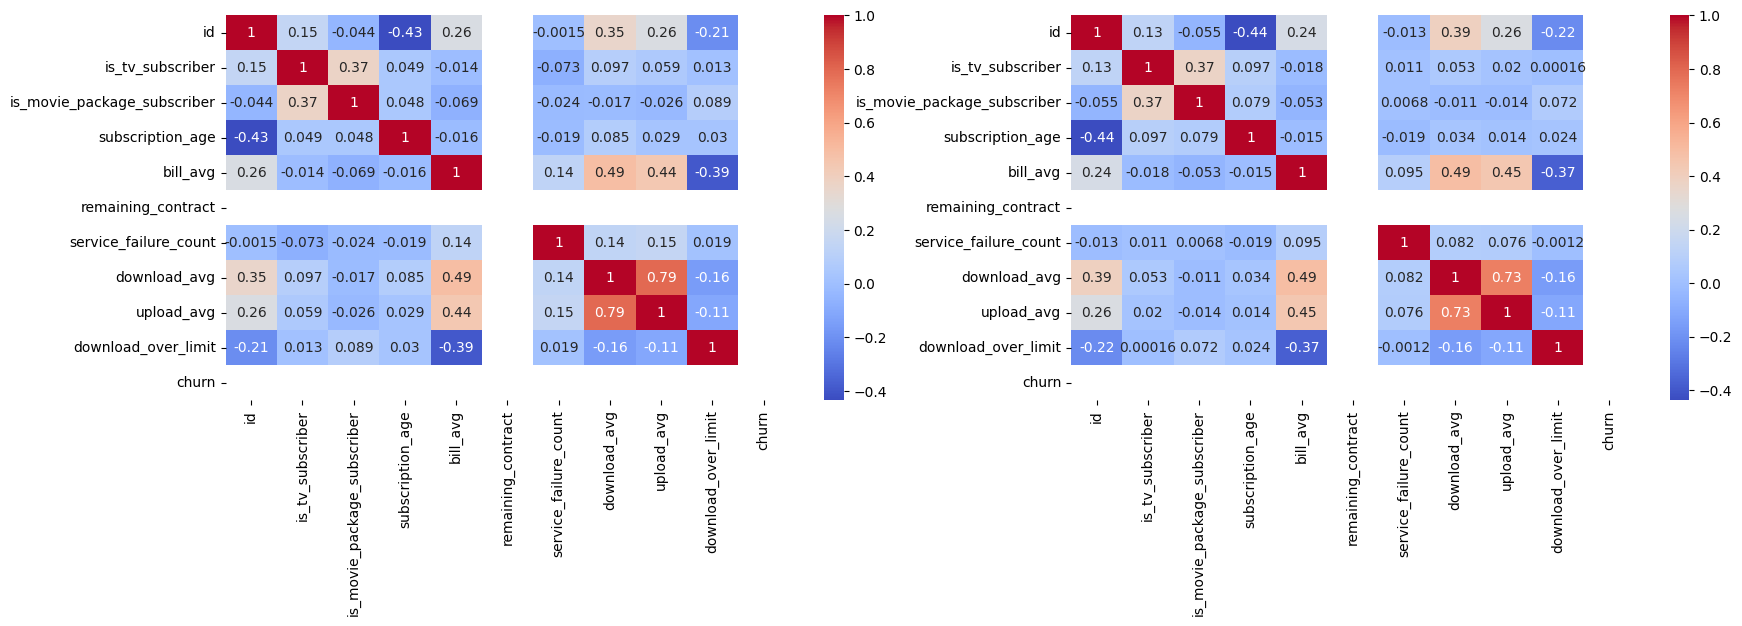

In [ ]:
if load_data == 0:
  fns.corr_comparison(NaN_ch_1_train, NaN_ch_1_test)

In [ ]:
if load_data == 0:
  ss_cor_arr, ss_sta_arr = fns.create_corr_and_stats_arrays(NaN_ch_1_test.drop(columns=[rc, ch]))
  tr_cor_arr, tr_sta_arr = fns.create_corr_and_stats_arrays(NaN_ch_1_train.drop(columns=[rc, ch]))

  secret_error1 = fns.error_fun1(tr_cor_arr, tr_sta_arr, ss_cor_arr, ss_sta_arr)
  secret_error2 = fns.error_fun2(tr_cor_arr, tr_sta_arr, ss_cor_arr, ss_sta_arr)
  sum_secret_error = secret_error1 + secret_error2
  #obliczenie błędu dla próbki startowej


  print(f"Initial error1 (cor) = {secret_error1} \nInitial error2 (sta) = {secret_error2} \nInitial error3 (cor_churn) =  ")

Initial error1 (cor) = 0.0752635801901124 
Initial error2 (sta) = 5508548.332822058 
Initial error3 (cor_churn) =  


In [ ]:
if load_data == 0:
  # Optymalizacja na bazie Monte Carlo K kroków -  tą komórkę można uruchamiać ponownie, jeśli wyniki nie są satysfakcjonujące
  K = 5000

  w1 = 1.0
  w2 = 1.0



  for i in range(K):


    new_NaN_ch_1_train, new_NaN_ch_1_test = train_test_split(NaN_ch_1, test_size=test_size)
    ss_cor_arr, ss_sta_arr = fns.create_corr_and_stats_arrays(NaN_ch_1_test.drop(columns=[rc, ch]))
    tr_cor_arr, tr_sta_arr = fns.create_corr_and_stats_arrays(NaN_ch_1_train.drop(columns=[rc, ch]))

    new_error1 = fns.error_fun1(tr_cor_arr, tr_sta_arr, ss_cor_arr, ss_sta_arr)
    new_error2 = fns.error_fun2(tr_cor_arr, tr_sta_arr, ss_cor_arr, ss_sta_arr)


    if (new_error1 < w1*secret_error1) and (new_error2 < w2*secret_error2):

      secret_error1 = new_error1
      secret_error2 = new_error2

      NaN_ch_1_test = new_NaN_ch_1_test
      NaN_ch_1_train = new_NaN_ch_1_train
      print(f" i = {i}\nError1 (cor) = {secret_error1} \nError2 (sta) = {secret_error2} \nError3 (cor_churn) =  \n\n\n")


  print(f" Error1 (cor) = {secret_error1} \nError2 (sta) = {secret_error2} \nError3 (cor_churn) =  ")

  steps += K
  print(f"\nNumber of all iterations: {steps}\n")
  print(f"\ntest size: {test_size}")

 Error1 (cor) = 0.0752635801901124 
Error2 (sta) = 5508548.332822058 
Error3 (cor_churn) =  

Number of all iterations: 10000


test size: 0.9


Błędy z poszczególnych uruchomień podziału od nowa


---


Error1 (cor) = 0.12683586915102996
Error2 (sta) = 9205272.612528281
Error3 (cor_churn) =  

Number of all iterations: 20000

test size: 0.9


---
 Error1 (cor) = 0.04676176345441678
Error2 (sta) = 89123892.3414348
Error3 (cor_churn) =  

Number of all iterations: 25000


test size: 0.9




In [ ]:
save_data = 1

In [ ]:
filepath_train = "/content/NaN_ch_1_train.csv"
filepath_test = "/content/NaN_ch_1_test.csv"

In [ ]:
if save_data == 1:
  NaN_ch_1_test.to_csv(filepath_test, index=False)
  NaN_ch_1_train.to_csv(filepath_train, index=False)


In [ ]:
if load_data == 1:
  NaN_ch_1_test = pd.read_csv(filepath_test)
  NaN_ch_1_train = pd.read_csv(filepath_train)


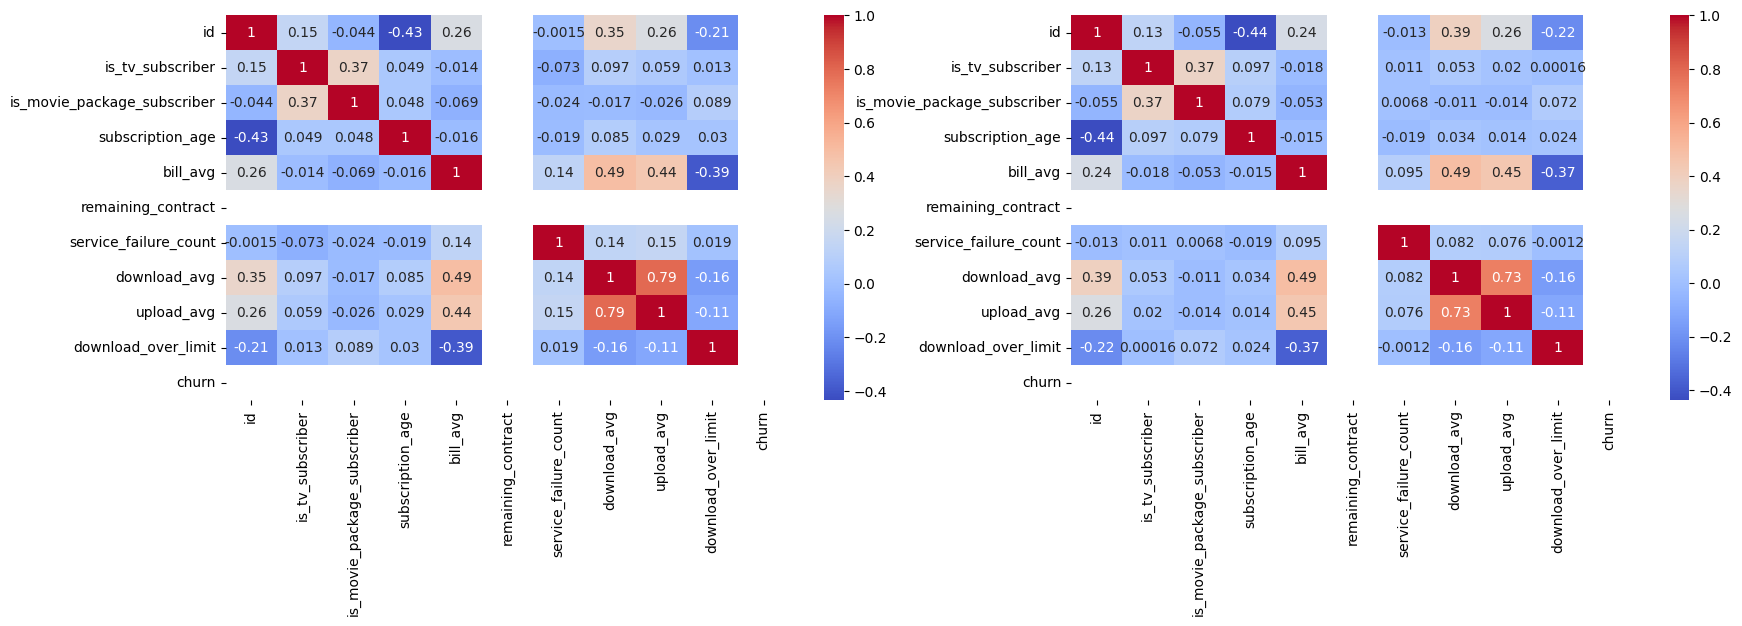

In [ ]:
fns.corr_comparison(NaN_ch_1_train, NaN_ch_1_test)

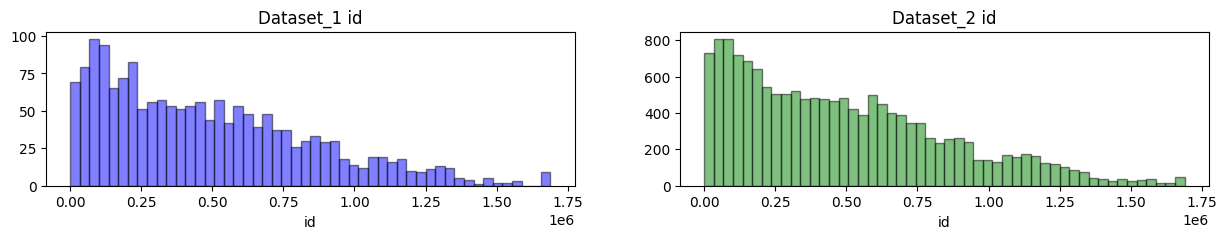

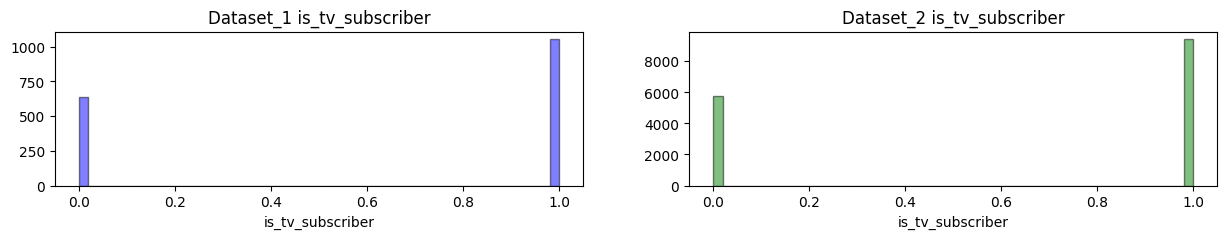

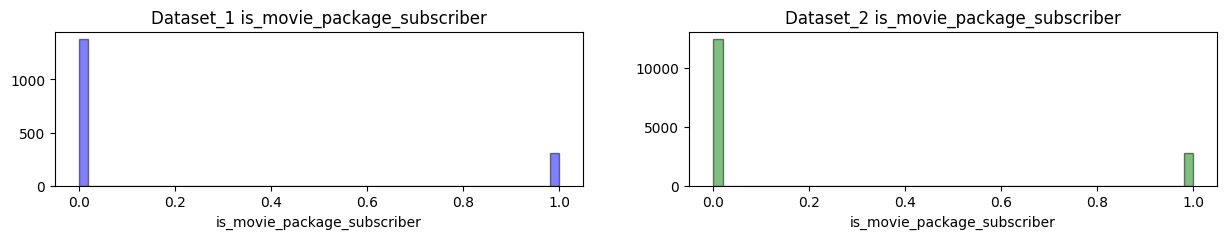

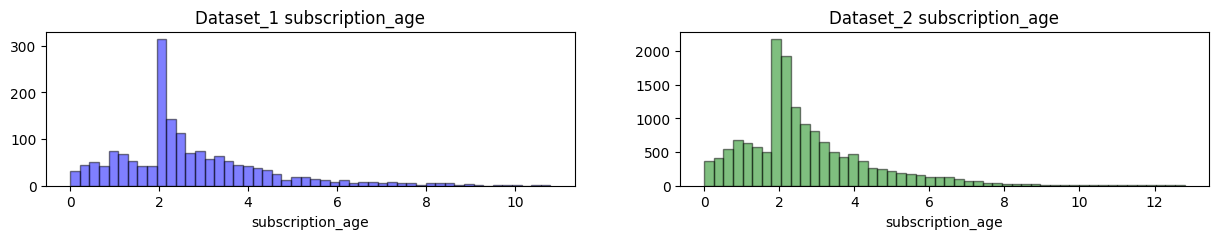

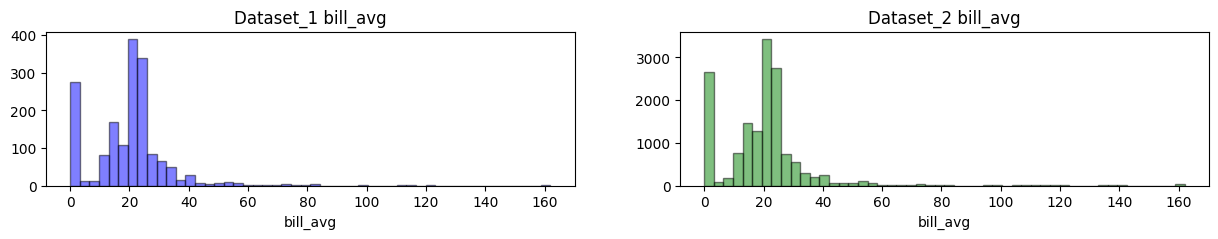

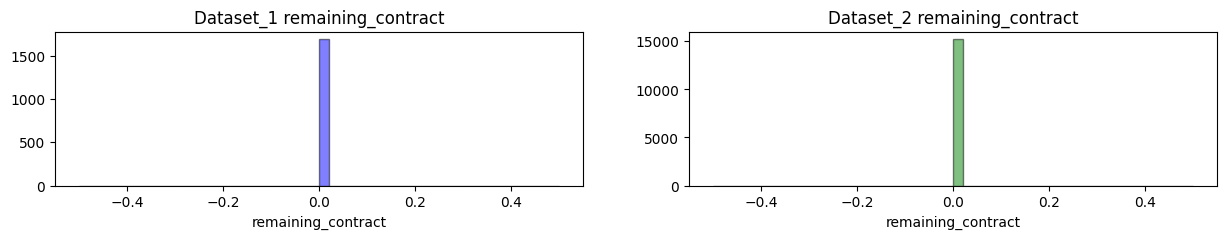

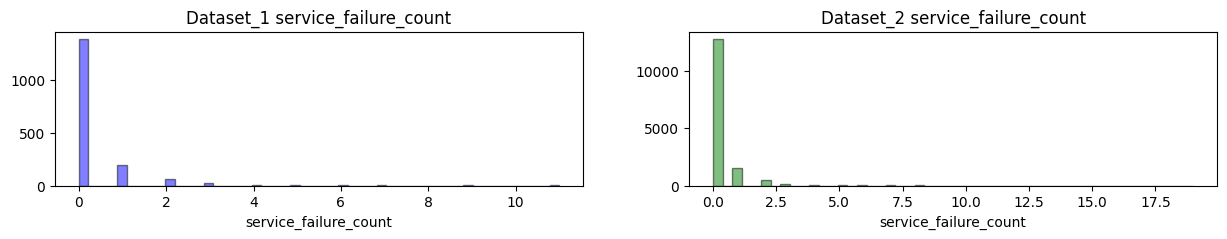

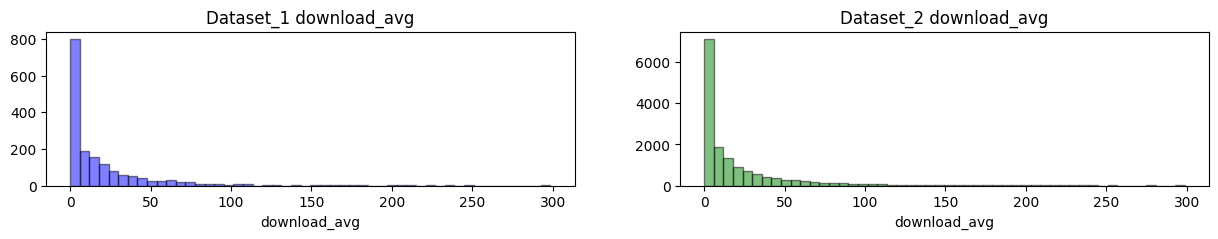

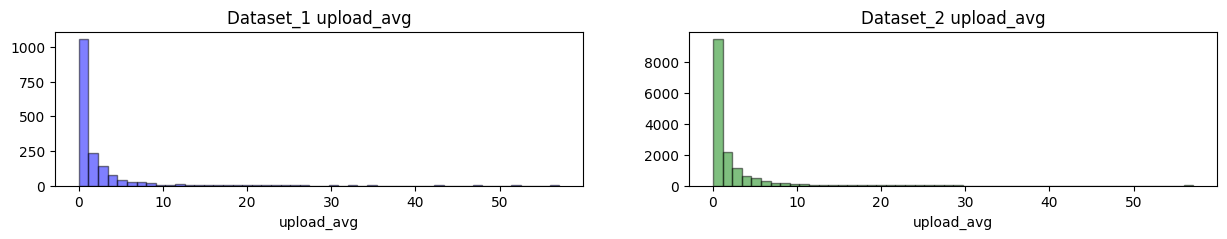

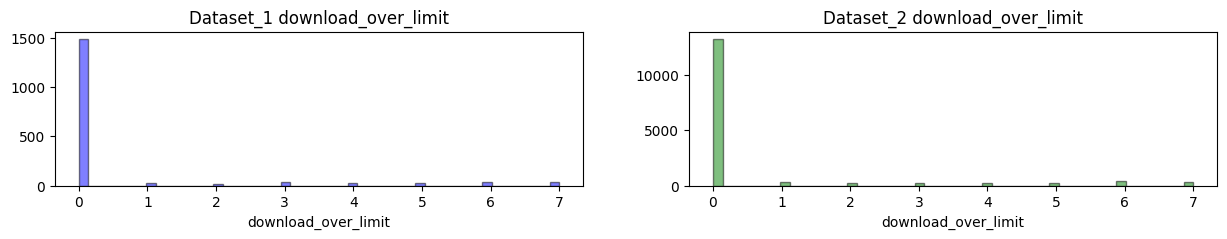

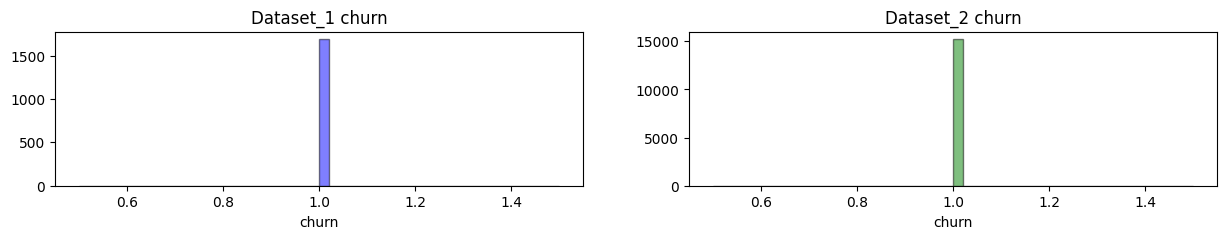

In [ ]:
fns.hist_comparison(NaN_ch_1_train, NaN_ch_1_test)

In [ ]:
NaN_df_1 = shuffle(pd.concat([NaN_ch_0, NaN_ch_1_train]))
NaN_df_1.head()

id  is_tv_subscriber  is_movie_package_subscriber  \
22136   603334                 1                            0   
15665   425378                 1                            0   
38287  1039918                 1                            0   
41114  1117433                 0                            0   
990      26855                 0                            0   

       subscription_age  bill_avg  remaining_contract  service_failure_count  \
22136              5.49        24                 0.0                      0   
15665              6.29        22                 0.0                      0   
38287              2.82        73                 0.0                      0   
41114              2.38        21                 0.0                      1   
990                4.69        23                 0.0                      1   

       download_avg  upload_avg  download_over_limit  churn  
22136          30.4         3.6                    0      0  
15665          56.1         4.9                    0      0  
38287         182.1         6.7                    0      0  
41114          92.5         8.7                    0      0  
990            19.1         2.4                    0      1

In [ ]:
NaN_df_1.describe()

id  is_tv_subscriber  is_movie_package_subscriber  \
count  3.294000e+03       3294.000000                  3294.000000   
mean   6.567842e+05          0.675774                     0.207650   
std    4.407189e+05          0.468156                     0.405687   
min    8.400000e+01          0.000000                     0.000000   
25%    2.660658e+05          0.000000                     0.000000   
50%    6.133320e+05          1.000000                     0.000000   
75%    1.053668e+06          1.000000                     0.000000   
max    1.689530e+06          1.000000                     1.000000   

       subscription_age     bill_avg  remaining_contract  \
count       3294.000000  3294.000000              3294.0   
mean           3.362659    24.989071                 0.0   
std            2.263939    22.268518                 0.0   
min            0.000000     0.000000                 0.0   
25%            1.982500    16.000000                 0.0   
50%            2.610000    22.000000                 0.0   
75%            4.545000    27.000000                 0.0   
max           11.930000   162.000000                 0.0   

       service_failure_count  download_avg   upload_avg  download_over_limit  \
count            3294.000000   3294.000000  3294.000000          3294.000000   
mean                0.270492     45.213479     5.115118             0.372799   
std                 0.780103     65.051015    10.607312             1.323960   
min                 0.000000      0.000000     0.000000             0.000000   
25%                 0.000000      4.200000     0.400000             0.000000   
50%                 0.000000     21.200000     1.800000             0.000000   
75%                 0.000000     56.800000     4.700000             0.000000   
max                11.000000    298.700000    57.100000             7.000000   

             churn  
count  3294.000000  
mean      0.513661  
std       0.499889  
min       0.000000  
25%       0.000000  
50%       1.000000  
75%       1.000000  
max       1.000000

In [ ]:
NaN_df_1_std = std_machine(NaN_df_1)

In [ ]:

def models_machine(df: pd.DataFrame, test_size = 0.2):


  X, y = Xy_split(shuffle(df))

  #poly = PolynomialFeatures(degree=2)
  #X = poly.fit_transform(X)
  print(X.shape)

  model_log_reg = LogisticRegression( random_state=1, solver='lbfgs', max_iter = 500)


  model_svm = svm.SVC(C=1, kernel='rbf')


  model_ran_for = RandomForestClassifier(n_estimators=20, criterion='entropy', max_depth=6, random_state=13)


  model_xgb = XGBClassifier(n_estimators=20, max_depth=4 ,random_state=13)



  models = {
            'lr': model_log_reg,
            'svm': model_svm,
            'rf': model_ran_for,
            'xgb': model_xgb
            }


  #for value in models.values():
  #  value.fit(X, y)


  for key, value in models.items():
    print(key)
    scores = cross_val_score(value, X, y, cv=6, scoring='accuracy')
    print(f"cross validation accuracy mean = {scores.mean()}")

    value.fit(X, y)
    print(f"score = {value.score(X, y)}")



  return models

In [ ]:
models_0 = models_machine(NaN_df_1_std[[id, sa, ch]])

(3294, 2)
lr
cross validation accuracy mean = 0.922890103217972
score = 0.9231936854887675
svm
cross validation accuracy mean = 0.9253187613843351
score = 0.9262295081967213
rf
cross validation accuracy mean = 0.9359441408621737
score = 0.940194292653309
xgb
cross validation accuracy mean = 0.9395871281117182
score = 0.9571948998178507


In [ ]:
models_1 = models_machine(NaN_df_1_std)

(3294, 10)
lr
cross validation accuracy mean = 0.9247115968427444
score = 0.9253187613843351
svm
cross validation accuracy mean = 0.9101396478445659
score = 0.9183363691560413
rf
cross validation accuracy mean = 0.8882817243472981
score = 0.9104432301153612
xgb
cross validation accuracy mean = 0.9353369763205829
score = 0.9493017607771707


In [ ]:
models_2 = models_machine(NaN_df_1_std.drop(columns=[rc, id]))

(3294, 8)
lr
cross validation accuracy mean = 0.7577413479052822
score = 0.7589556769884639
svm
cross validation accuracy mean = 0.7820279295689132
score = 0.7926533090467517
rf
cross validation accuracy mean = 0.7844565877352764
score = 0.8026715239829993
xgb
cross validation accuracy mean = 0.8008500303582271
score = 0.8248330297510625


In [ ]:
models_3 = models_machine(NaN_df_1_std.drop(columns=[rc, sa, id]))

(3294, 7)
lr
cross validation accuracy mean = 0.7170613236187008
score = 0.7191863995142683
svm
cross validation accuracy mean = 0.7255616272009714
score = 0.7364905889496054
rf
cross validation accuracy mean = 0.7501517911353978
score = 0.769277474195507
xgb
cross validation accuracy mean = 0.7632058287795992
score = 0.8044930176077717


In [ ]:
def models_combine(df: pd.DataFrame, test_size = 0.2):

  X, y = Xy_split(df)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=31)


  model_log_reg = LogisticRegression( random_state=1, solver='lbfgs', max_iter = 500)
  model_log_reg.fit(X, y)
  prob_log_reg = model_log_reg.predict_proba(X)[:,1]
  pr1 = pd.Series(prob_log_reg, name="prob1")



  model_svm = svm.SVC(C=1, kernel='poly', probability=True)
  model_svm.fit(X, y)
  prob_svm = model_svm.predict_proba(X)[:,1]
  pr2 = pd.Series(prob_svm, name="prob2")


  model_ran_for = RandomForestClassifier(n_estimators=30, criterion='gini', max_depth=6, random_state=13)
  model_ran_for.fit(X, y)
  prob_ran_for = model_ran_for.predict_proba(X)[:,1]
  pr3 = pd.Series(prob_ran_for, name="prob3")




  new_df = pd.concat([pr1, pr2, pr3, df], axis=1)

  models = models_machine(new_df, test_size)
  return models





In [ ]:
NaN_df_1_std[[id, sa, ch]].head()

id  subscription_age  churn
0 -0.121298          0.939806      0
1 -0.525145          1.293226      0
2  0.869470         -0.239733      0
3  1.045380         -0.434114      0
4 -1.429539          0.586386      1

In [ ]:
models_0_comb = models_combine(NaN_df_1_std[[id, sa, ch]])

(3294, 5)
lr
cross validation accuracy mean = 0.9632665452337582
score = 0.9638737097753491
svm
cross validation accuracy mean = 0.9641772920461444
score = 0.9650880388585307
rf
cross validation accuracy mean = 0.9833029751062538
score = 0.9872495446265938
xgb
cross validation accuracy mean = 0.98421372191864
score = 0.9893746205221615


In [ ]:
models_1_comb = models_combine(NaN_df_1_std)

(3294, 13)
lr
cross validation accuracy mean = 0.9380692167577415
score = 0.9383727990285368
svm
cross validation accuracy mean = 0.9326047358834244
score = 0.9377656344869459
rf
cross validation accuracy mean = 0.9456587735276262
score = 0.949605343047966
xgb
cross validation accuracy mean = 0.9571948998178507
score = 0.9738919247115968


In [ ]:
models_2_comb = models_combine(NaN_df_1_std.drop(columns=[rc, id]))

(3294, 11)
lr
cross validation accuracy mean = 0.8139040680024286
score = 0.8148148148148148
svm
cross validation accuracy mean = 0.8063145112325439
score = 0.8136004857316332
rf
cross validation accuracy mean = 0.8181542197935641
score = 0.840922890103218
xgb
cross validation accuracy mean = 0.829083181542198
score = 0.8670309653916212


In [ ]:
models_3_comb = models_machine(NaN_df_1_std.drop(columns=[rc, sfc, id]))

(3294, 7)
lr
cross validation accuracy mean = 0.7562234365513055
score = 0.7595628415300546
svm
cross validation accuracy mean = 0.7814207650273225
score = 0.7923497267759563
rf
cross validation accuracy mean = 0.7874924104432303
score = 0.8032786885245902
xgb
cross validation accuracy mean = 0.7981177899210685
score = 0.8254401942926534


Sprawdzenie trafności modeli z podziałem na ch=0 i ch=1

In [ ]:
bool_vecs_NaN_1_std_ch = {
    "ch == 0": NaN_df_1_std[ch] == 0,
    "ch == 1": NaN_df_1_std[ch] == 1,
}

sub_NaN1s_std_ch = fns.create_subdfs_list(NaN_df_1_std, bool_vecs_NaN_1_std_ch)

(1602, 11)
(1692, 11)


In [ ]:
for key, value in models_2.items():
  print(key)
  print(value.score(*Xy_split(sub_NaN1s_std_ch[1].drop(columns=[id, rc]))) )

lr
0.8126477541371159
svm
0.789598108747045
rf
0.7659574468085106
xgb
0.7960992907801419


In [ ]:
for key, value in models_2.items():
  print(key)
  print(value.score(*Xy_split(sub_NaN1s_std_ch[0].drop(columns=[id, rc]))) )

lr
0.702247191011236
svm
0.795880149812734
rf
0.8414481897627965
xgb
0.8551810237203495


Sprawdzenie na próbkach rc=NaN ch=1, które nie były wykorzystane do treningu. Idealny model nie powinien się mylić.

In [ ]:
NaN_ch_1_test_std = std_machine_only_trans(NaN_ch_1_test)

In [ ]:
for key, value in models_2.items():
  print(key)
  print(value.score(*Xy_split(NaN_ch_1_test_std.drop(columns=[id, rc]))) )

lr
0.8003939592908733
svm
0.758962573867367
rf
0.7298752462245568
xgb
0.7594878529218647


Sprawdzenie jak zachowuje się model na próbkach rc>0.
Należy się spodziewać, że tam gdzie ch=1, czyli klienci odeszli wypowiadając umowę przed końcem, **idealny** model nie będzie się mylił.
Tam natomiast, gdzie ch=0, czyli klienci aktualnie są jeszcze klientami, model może "mylić się", wskazania modelu mają bowiem informować, czy dany klient ma powody, żeby zrezygnować z usług, a więc, czy jest prawdopodobne, że zrobi to, jak tylko skończy mu się umowa.

In [ ]:
gt0_df = df_subs_rc[1]
gt0_df.head()

id  is_tv_subscriber  is_movie_package_subscriber  subscription_age  \
0    15                 1                            0             11.95   
5    56                 1                            1             11.94   
11  174                 1                            1             11.93   
14  270                 0                            0              6.97   
15  288                 1                            1             11.93   

    bill_avg  remaining_contract  service_failure_count  download_avg  \
0         25                0.14                      0           8.4   
5         32                1.38                      0          69.4   
11        10                1.28                      0          10.6   
14        23                0.28                      0           0.0   
15        18                1.80                      0           1.0   

    upload_avg  download_over_limit  churn  
0          2.3                    0      0  
5          4.0                    0      0  
11         0.6                    0      0  
14         0.0                    0      1  
15         0.0                    0      0

In [ ]:
print(scaler.get_params())

{'copy': True, 'with_mean': True, 'with_std': True}


In [ ]:
gt0_X_df_sdt = std_machine_only_trans(gt0_df)

In [ ]:
bool_vecs_gt0_std_ch = {
    "ch == 0": gt0_X_df_sdt[ch] == 0,
    "ch == 1": gt0_X_df_sdt[ch] == 1,
}

sub_gt0s_std_ch = fns.create_subdfs_list(gt0_X_df_sdt, bool_vecs_gt0_std_ch)

(26108, 11)
(3501, 11)


In [ ]:
for key, value in models_2.items():
  print(key)
  print(value.score(*Xy_split(sub_gt0s_std_ch[1].drop(columns=[id, rc]))) )

lr
0.6778063410454156
svm
0.5381319622964867
rf
0.4921451013996001
xgb
0.5181376749500143


In [ ]:
for key, value in models_2.items():
  print(key)
  print(value.score(*Xy_split(sub_gt0s_std_ch[0].drop(columns=[id, rc]))) )

lr
0.5572621418722231
svm
0.7423395127930137
rf
0.7968055768346867
xgb
0.7678872376283131


Gdyby model był dobry, powyższe wyniki wskazywałyby jaki procent klientów prawdopodobnie odejdzie, gdy skończy im się umowa. Niestety zbudowany model nie jest godny zaufania.

---


**PODEJŚCIE 3 - wyrzucone**


Nowe podejście, churn=1 wezmę z grupy rc>0, gdyż są to prawdopodobnie klienci, którzy mieli mocne powody, żeby zrezygnować z usług, skoro wypowiedzieli umowę przed jej zakończeniem

Kroki, które możnaby jeszcze podjąć:

*   Szczegółowa analiza klientów, dla których bill_avg=0 (nie mają żadnych rachunków?) da=0, ua=0 (nie skorzystali z internetu wcale)

*   Element listy






**PODSUMOWANIE**

Podjęto próbę zbudowania modelu, który będzie przewidywał, czy klient zrezygnuje z usług w przyszłości (gdy skończy mu się umowa), na podstawie danych o rezygnacjach z przeszłości. Modele budowano i trenowano "na klientach", którzy mieli umowę na cas nieokreślony w oparciu o założenie, że klient taki, jeśli miał powody, żeby zrezygnować to zrezygnował, a jeśli ich nie miał, to nie zrezygnował. Otrzymane wyniki raczej należy interpretować jako porażkę, co może oznaczać, że:


1.   Modele są słabej jakości (niewystarczająco dobrej). Nie udał się sam model.
2.   Błędne było założenie, tj. klient, który teoretycznie miał powody, żeby zrezygnować z usług, wcale nie zrezygnował (bo np nie miał czasu na szukanie innego dostawcy internetu), a klient, który teoretycznie powodów nie miał (albo powody nie są ujęte w datasecie) jednak zrezygnował (bo np miał takie "widzimisię")
3.   Ilość cech w datasecie jest zbyt mała i część powodów rezygnacji nie jest w nim ujęta
4.   Potrzebna jest bardziej szczegółowa analiza i lepszy dobór danych do treningu


Tej części pracy nie da się porównać z pozostałymi, gdyż jest, de facto, rozwiązaniem, albo próbą rozwiązania, nieco innego zadania. Zbiór "secret" nie został wykorzystany.








